In [40]:
import os
# import pkg_resources
# pkg_resources.require('Torch==2.0.1')
!pip install torch==2.0.1
import torch
print('Using torch', torch.__version__)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install ogb
!pip install rdkit-pypi

Using torch 2.0.1+cu117
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [54]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.utils import degree
from torch_geometric.utils import to_dense_batch

from ogb.graphproppred.mol_encoder import BondEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gsp

from torch_geometric.utils import to_dense_batch

# from models.layers import SAB, ISAB, PMA
# from models.layers import GCNConv_for_OGB, GINConv_for_OGB

from ogb.graphproppred.mol_encoder import AtomEncoder

from math import ceil

# set seed
seed_value = 108
torch.manual_seed(seed_value)

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False, cluster=False, conv=None):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)

        self.fc_k, self.fc_v = self.get_fc_kv(dim_K, dim_V, conv)

        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

        self.softmax_dim = 2
        if cluster == True:
            self.softmax_dim = 1

    def forward(self, Q, K, attention_mask=None, graph=None, return_attn=False):
        Q = self.fc_q(Q)

        # Adj: Exist (graph is not None), or Identity (else)
        if graph is not None:

            (x, edge_index, batch) = graph

            K, V = self.fc_k(x, edge_index), self.fc_v(x, edge_index)

            K, _ = to_dense_batch(K, batch)
            V, _ = to_dense_batch(V, batch)

        else:

            K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        if attention_mask is not None:
            attention_mask = torch.cat([attention_mask for _ in range(self.num_heads)], 0)
            attention_score = Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V)
            A = torch.softmax(attention_mask + attention_score, self.softmax_dim)
        else:
            A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), self.softmax_dim)

        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        if return_attn:
            return O, A
        else:
            return O

    def get_fc_kv(self, dim_K, dim_V, conv):

        if conv == 'GCN':

            fc_k = GCNConv(dim_K, dim_V)
            fc_v = GCNConv(dim_K, dim_V)

        elif conv == 'GIN':

            fc_k = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

            fc_v = GINConv(
                nn.Sequential(
                    nn.Linear(dim_K, dim_K),
                    nn.ReLU(),
                    nn.Linear(dim_K, dim_V),
                    nn.ReLU(),
                    nn.BatchNorm1d(dim_V),
            ), train_eps=False)

        else:

            fc_k = nn.Linear(dim_K, dim_V)
            fc_v = nn.Linear(dim_K, dim_V)

        return fc_k, fc_v

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False, cluster=False, mab_conv=None):
        super(SAB, self).__init__()

        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        return self.mab(X, X, attention_mask, graph)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False, cluster=False, mab_conv=None):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)

        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X, attention_mask, graph)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False, cluster=False, mab_conv=None):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)

        self.mab = MAB(dim, dim, dim, num_heads, ln=ln, cluster=cluster, conv=mab_conv)

    def forward(self, X, attention_mask=None, graph=None, return_attn=False):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X, attention_mask, graph, return_attn)

### GCN convolution along the graph structure
class GCNConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GCNConv_for_OGB, self).__init__(aggr='add')

        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)

        row, col = edge_index

        deg = degree(row, x.size(0), dtype = x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight) * 1./deg.view(-1,1)

    def message(self, x_j, edge_attr, norm):
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

### GIN convolution along the graph structure
class GINConv_for_OGB(MessagePassing):
    def __init__(self, emb_dim):
        super(GINConv_for_OGB, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

In [42]:
class GraphRepresentation(torch.nn.Module):

    def __init__(self, args):

        super(GraphRepresentation, self).__init__()

        self.args = args
        self.num_features = args.num_features
        self.nhid = args.num_hidden
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout

    def get_convs(self):

        convs = nn.ModuleList()

        _input_dim = self.num_features
        _output_dim = self.nhid

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv(_input_dim, _output_dim)

            elif self.args.conv == 'GIN':

                conv = GINConv(
                    nn.Sequential(
                        nn.Linear(_input_dim, _output_dim),
                        nn.ReLU(),
                        nn.Linear(_output_dim, _output_dim),
                        nn.ReLU(),
                        nn.BatchNorm1d(_output_dim),
                ), train_eps=False)

            convs.append(conv)

            _input_dim = _output_dim
            _output_dim = _output_dim

        return convs

    def get_pools(self):

        pools = nn.ModuleList([gap])

        return pools

    def get_classifier(self):

        return nn.Sequential(
            nn.Linear(self.nhid, self.nhid),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid, self.nhid//2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(self.nhid//2, self.num_classes)
        )

class GraphMultisetTransformer(GraphRepresentation):

    def __init__(self, args):

        super(GraphMultisetTransformer, self).__init__(args)

        self.ln = args.ln
        self.num_heads = args.num_heads
        self.cluster = args.cluster

        self.model_sequence = args.model_string.split('-')

        self.convs = self.get_convs()
        self.pools = self.get_pools()
        self.classifier = self.get_classifier()

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return F.log_softmax(x, dim=-1)

    def get_pools(self, _input_dim=None, reconstruction=False):

        pools = nn.ModuleList()

        _input_dim = self.nhid * self.args.num_convs if _input_dim is None else _input_dim
        _output_dim = self.nhid
        _num_nodes = ceil(self.pooling_ratio * self.args.avg_num_nodes)

        for _index, _model_str in enumerate(self.model_sequence):

            if (_index == len(self.model_sequence) - 1) and (reconstruction == False):

                _num_nodes = 1

            if _model_str == 'GMPool_G':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=self.args.mab_conv)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'GMPool_I':

                pools.append(
                    PMA(_input_dim, self.num_heads, _num_nodes, ln=self.ln, cluster=self.cluster, mab_conv=None)
                )

                _num_nodes = ceil(self.pooling_ratio * _num_nodes)

            elif _model_str == 'SelfAtt':

                pools.append(
                    SAB(_input_dim, _output_dim, self.num_heads, ln=self.ln, cluster=self.cluster)
                )

                _input_dim = _output_dim
                _output_dim = _output_dim

            else:

                raise ValueError("Model Name in Model String <{}> is Unknown".format(_model_str))

        pools.append(nn.Linear(_input_dim, self.nhid))

        return pools

class GraphMultisetTransformer_for_OGB(GraphMultisetTransformer):

    def __init__(self, args):

        super(GraphMultisetTransformer_for_OGB, self).__init__(args)

        self.atom_encoder = AtomEncoder(self.nhid)
        self.convs = self.get_convs()

    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.atom_encoder(x)

        # For Graph Convolution Network
        xs = []

        for _ in range(self.args.num_convs):

            x = F.relu(self.convs[_](x, edge_index, edge_attr))
            xs.append(x)

        # For jumping knowledge scheme
        x = torch.cat(xs, dim=1)

        # For Graph Multiset Transformer
        for _index, _model_str in enumerate(self.model_sequence):

            if _index == 0:

                batch_x, mask = to_dense_batch(x, batch)

                extended_attention_mask = mask.unsqueeze(1)
                extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9

            if _model_str == 'GMPool_G':

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask, graph=(x, edge_index, batch))

            else:

                batch_x = self.pools[_index](batch_x, attention_mask=extended_attention_mask)

            extended_attention_mask = None

        batch_x = self.pools[len(self.model_sequence)](batch_x)
        x = batch_x.squeeze(1)

        # For Classification
        x = self.classifier(x)

        return x

    def get_convs(self):

        convs = nn.ModuleList()

        for _ in range(self.args.num_convs):

            if self.args.conv == 'GCN':

                conv = GCNConv_for_OGB(self.nhid)

            elif self.args.conv == 'GIN':

                conv = GINConv_for_OGB(self.nhid)

            convs.append(conv)

        return convs

In [43]:
import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

from torch_scatter import scatter_mean


class NNDecoder(torch.nn.Module):
    def __init__(self, num_tasks, emb_dim, graph_pooling = "mean"):
        super().__init__()
        self.linear = torch.nn.Linear(emb_dim, num_tasks)

    def forward(self, node_rep):
      ## (~2-3 lines of code)
      output = self.linear(node_rep[:,0,:])
      return output


In [48]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, val_metrics, test_metrics, epoch_times):
    """
    Plot training loss, validation metric, and test metric over epochs.

    Parameters:
    - losses: List of training losses for each epoch.
    - val_metrics: List of validation metrics for each epoch.
    - test_metrics: List of test metrics for each epoch.
    """
    epochs = range(1, len(losses) + 1)

    # Plotting training loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, label='Training Loss', marker='o')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation and test metrics
    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_metrics, label='Validation Metric', marker='o')
    plt.plot(epochs, test_metrics, label='Test Metric', marker='o')
    plt.title('Validation and Test Metrics vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    # Plotting time vs. epoch
    plt.subplot(1, 3, 3)
    plt.plot(epochs, epoch_times, label='Time per Epoch', marker='o', color='orange')
    plt.title('Time vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_metrics(training_losses, validation_metrics, test_metrics)

617


100% 54/54 [00:02<00:00, 21.56it/s]


loss returned: 0.44660798637929533


100% 7/7 [00:00<00:00, 32.27it/s]
100% 7/7 [00:00<00:00, 34.14it/s]


Epoch: 001, Loss: 0.4466, Val Acc: {'rocauc': 0.4754325160986267}, Test Acc: {'rocauc': 0.5044796232439542}


100% 54/54 [00:01<00:00, 34.60it/s]


loss returned: 0.25030947138199655


100% 7/7 [00:00<00:00, 61.91it/s]
100% 7/7 [00:00<00:00, 58.18it/s]


Epoch: 002, Loss: 0.2503, Val Acc: {'rocauc': 0.48193606363848246}, Test Acc: {'rocauc': 0.5088891864493598}


100% 54/54 [00:01<00:00, 27.10it/s]


loss returned: 0.24553726779476198


100% 7/7 [00:00<00:00, 56.79it/s]
100% 7/7 [00:00<00:00, 65.42it/s]


Epoch: 003, Loss: 0.2455, Val Acc: {'rocauc': 0.48732077262519213}, Test Acc: {'rocauc': 0.5140537621124796}


100% 54/54 [00:01<00:00, 28.96it/s]


loss returned: 0.24420643533979144


100% 7/7 [00:00<00:00, 65.50it/s]
100% 7/7 [00:00<00:00, 65.50it/s]


Epoch: 004, Loss: 0.2442, Val Acc: {'rocauc': 0.48921035205355107}, Test Acc: {'rocauc': 0.5201796299741897}


100% 54/54 [00:01<00:00, 34.76it/s]


loss returned: 0.24343095695485875


100% 7/7 [00:00<00:00, 52.74it/s]
100% 7/7 [00:00<00:00, 60.83it/s]


Epoch: 005, Loss: 0.2434, Val Acc: {'rocauc': 0.4982497991926172}, Test Acc: {'rocauc': 0.5287151532113319}


100% 54/54 [00:02<00:00, 24.51it/s]


loss returned: 0.2426803992197743


100% 7/7 [00:00<00:00, 42.56it/s]
100% 7/7 [00:00<00:00, 67.11it/s]


Epoch: 006, Loss: 0.2427, Val Acc: {'rocauc': 0.5078973702774825}, Test Acc: {'rocauc': 0.5334430942043782}


100% 54/54 [00:01<00:00, 34.28it/s]


loss returned: 0.24224974872767058


100% 7/7 [00:00<00:00, 63.85it/s]
100% 7/7 [00:00<00:00, 66.46it/s]


Epoch: 007, Loss: 0.2422, Val Acc: {'rocauc': 0.5158356559396083}, Test Acc: {'rocauc': 0.5414082477285957}


100% 54/54 [00:01<00:00, 34.85it/s]


loss returned: 0.24084988603091448


100% 7/7 [00:00<00:00, 54.30it/s]
100% 7/7 [00:00<00:00, 63.38it/s]


Epoch: 008, Loss: 0.2408, Val Acc: {'rocauc': 0.5206724661281046}, Test Acc: {'rocauc': 0.5441947153580298}


100% 54/54 [00:01<00:00, 34.35it/s]


loss returned: 0.24110466420824256


100% 7/7 [00:00<00:00, 52.36it/s]
100% 7/7 [00:00<00:00, 46.58it/s]


Epoch: 009, Loss: 0.2411, Val Acc: {'rocauc': 0.5247872994758902}, Test Acc: {'rocauc': 0.5469772616864195}


100% 54/54 [00:01<00:00, 34.09it/s]


loss returned: 0.24047992569190768


100% 7/7 [00:00<00:00, 56.76it/s]
100% 7/7 [00:00<00:00, 63.53it/s]


Epoch: 010, Loss: 0.2405, Val Acc: {'rocauc': 0.530888147348296}, Test Acc: {'rocauc': 0.5504081516127989}


100% 54/54 [00:01<00:00, 34.19it/s]


loss returned: 0.2403640217753263


100% 7/7 [00:00<00:00, 59.06it/s]
100% 7/7 [00:00<00:00, 63.62it/s]


Epoch: 011, Loss: 0.2404, Val Acc: {'rocauc': 0.531358685618655}, Test Acc: {'rocauc': 0.5518662047460764}


100% 54/54 [00:01<00:00, 34.52it/s]


loss returned: 0.2401756319290695


100% 7/7 [00:00<00:00, 61.42it/s]
100% 7/7 [00:00<00:00, 64.05it/s]


Epoch: 012, Loss: 0.2402, Val Acc: {'rocauc': 0.5338545975117708}, Test Acc: {'rocauc': 0.5534628110125367}


100% 54/54 [00:02<00:00, 25.30it/s]


loss returned: 0.24033678047163493


100% 7/7 [00:00<00:00, 63.52it/s]
100% 7/7 [00:00<00:00, 68.15it/s]


Epoch: 013, Loss: 0.2403, Val Acc: {'rocauc': 0.5340211497916968}, Test Acc: {'rocauc': 0.5575138709460309}


100% 54/54 [00:01<00:00, 34.90it/s]


loss returned: 0.24041435299739894


100% 7/7 [00:00<00:00, 65.28it/s]
100% 7/7 [00:00<00:00, 64.72it/s]


Epoch: 014, Loss: 0.2404, Val Acc: {'rocauc': 0.5382517617670574}, Test Acc: {'rocauc': 0.5578790822441818}


100% 54/54 [00:01<00:00, 34.33it/s]


loss returned: 0.24035826153379836


100% 7/7 [00:00<00:00, 62.65it/s]
100% 7/7 [00:00<00:00, 65.41it/s]


Epoch: 015, Loss: 0.2404, Val Acc: {'rocauc': 0.5387157659357834}, Test Acc: {'rocauc': 0.5578269882396264}


100% 54/54 [00:01<00:00, 27.89it/s]


loss returned: 0.23979148056694788


100% 7/7 [00:00<00:00, 40.68it/s]
100% 7/7 [00:00<00:00, 44.55it/s]


Epoch: 016, Loss: 0.2398, Val Acc: {'rocauc': 0.5412262624977419}, Test Acc: {'rocauc': 0.5655371659851369}


100% 54/54 [00:01<00:00, 34.79it/s]


loss returned: 0.23980511320923228


100% 7/7 [00:00<00:00, 57.43it/s]
100% 7/7 [00:00<00:00, 66.60it/s]


Epoch: 017, Loss: 0.2398, Val Acc: {'rocauc': 0.5442564216407596}, Test Acc: {'rocauc': 0.5633556151079125}


100% 54/54 [00:01<00:00, 34.30it/s]


loss returned: 0.23951709503335092


100% 7/7 [00:00<00:00, 63.88it/s]
100% 7/7 [00:00<00:00, 59.31it/s]


Epoch: 018, Loss: 0.2395, Val Acc: {'rocauc': 0.5448794318179866}, Test Acc: {'rocauc': 0.5656329098684791}


100% 54/54 [00:01<00:00, 34.04it/s]


loss returned: 0.23924012876634349


100% 7/7 [00:00<00:00, 57.62it/s]
100% 7/7 [00:00<00:00, 40.20it/s]


Epoch: 019, Loss: 0.2392, Val Acc: {'rocauc': 0.543163330147372}, Test Acc: {'rocauc': 0.5657965252804896}


100% 54/54 [00:01<00:00, 29.78it/s]


loss returned: 0.2389745942531452


100% 7/7 [00:00<00:00, 62.47it/s]
100% 7/7 [00:00<00:00, 63.45it/s]


Epoch: 020, Loss: 0.2390, Val Acc: {'rocauc': 0.544750670927673}, Test Acc: {'rocauc': 0.5680912161049674}


100% 54/54 [00:01<00:00, 33.97it/s]


loss returned: 0.23886446030946237


100% 7/7 [00:00<00:00, 59.62it/s]
100% 7/7 [00:00<00:00, 61.98it/s]


Epoch: 021, Loss: 0.2389, Val Acc: {'rocauc': 0.5440568661629318}, Test Acc: {'rocauc': 0.5685120471881652}


100% 54/54 [00:01<00:00, 34.21it/s]


loss returned: 0.23886193337662923


100% 7/7 [00:00<00:00, 62.90it/s]
100% 7/7 [00:00<00:00, 64.95it/s]


Epoch: 022, Loss: 0.2389, Val Acc: {'rocauc': 0.5455300478620215}, Test Acc: {'rocauc': 0.5699323877095454}


100% 54/54 [00:02<00:00, 23.17it/s]


loss returned: 0.2388880061425551


100% 7/7 [00:00<00:00, 42.04it/s]
100% 7/7 [00:00<00:00, 65.34it/s]


Epoch: 023, Loss: 0.2389, Val Acc: {'rocauc': 0.5502902440891219}, Test Acc: {'rocauc': 0.5719223099247795}


100% 54/54 [00:01<00:00, 34.07it/s]


loss returned: 0.23884303241359944


100% 7/7 [00:00<00:00, 56.87it/s]
100% 7/7 [00:00<00:00, 54.21it/s]


Epoch: 024, Loss: 0.2388, Val Acc: {'rocauc': 0.553873899570557}, Test Acc: {'rocauc': 0.571217897287285}


100% 54/54 [00:01<00:00, 33.98it/s]


loss returned: 0.23849728665268455


100% 7/7 [00:00<00:00, 62.78it/s]
100% 7/7 [00:00<00:00, 64.43it/s]


Epoch: 025, Loss: 0.2385, Val Acc: {'rocauc': 0.5531772601951624}, Test Acc: {'rocauc': 0.5720394232387322}


100% 54/54 [00:01<00:00, 31.25it/s]


loss returned: 0.23833983515337676


100% 7/7 [00:00<00:00, 41.71it/s]
100% 7/7 [00:00<00:00, 43.20it/s]


Epoch: 026, Loss: 0.2383, Val Acc: {'rocauc': 0.5559275849785843}, Test Acc: {'rocauc': 0.5743227966218583}


100% 54/54 [00:01<00:00, 34.03it/s]


loss returned: 0.2379222162089612


100% 7/7 [00:00<00:00, 62.33it/s]
100% 7/7 [00:00<00:00, 64.14it/s]


Epoch: 027, Loss: 0.2379, Val Acc: {'rocauc': 0.5571392568693846}, Test Acc: {'rocauc': 0.5758449912351373}


100% 54/54 [00:01<00:00, 33.94it/s]


loss returned: 0.23815053072337158


100% 7/7 [00:00<00:00, 65.59it/s]
100% 7/7 [00:00<00:00, 65.42it/s]


Epoch: 028, Loss: 0.2382, Val Acc: {'rocauc': 0.5574063151272006}, Test Acc: {'rocauc': 0.576831589927141}


100% 54/54 [00:01<00:00, 34.25it/s]


loss returned: 0.23800105293533894


100% 7/7 [00:00<00:00, 56.70it/s]
100% 7/7 [00:00<00:00, 57.30it/s]


Epoch: 029, Loss: 0.2380, Val Acc: {'rocauc': 0.56134687146777}, Test Acc: {'rocauc': 0.5803281990123483}


100% 54/54 [00:02<00:00, 26.99it/s]


loss returned: 0.23753837630283034


100% 7/7 [00:00<00:00, 58.91it/s]
100% 7/7 [00:00<00:00, 61.70it/s]


Epoch: 030, Loss: 0.2375, Val Acc: {'rocauc': 0.5622367714639502}, Test Acc: {'rocauc': 0.5801930111567813}


100% 54/54 [00:01<00:00, 33.67it/s]


loss returned: 0.2379813145444275


100% 7/7 [00:00<00:00, 61.04it/s]
100% 7/7 [00:00<00:00, 62.09it/s]


Epoch: 031, Loss: 0.2380, Val Acc: {'rocauc': 0.5679999557617708}, Test Acc: {'rocauc': 0.5818537233682401}


100% 54/54 [00:01<00:00, 34.23it/s]


loss returned: 0.23731963945547277


100% 7/7 [00:00<00:00, 53.97it/s]
100% 7/7 [00:00<00:00, 63.02it/s]


Epoch: 032, Loss: 0.2373, Val Acc: {'rocauc': 0.569405820849073}, Test Acc: {'rocauc': 0.5824279976955381}


100% 54/54 [00:02<00:00, 25.38it/s]


loss returned: 0.23767361388957187


100% 7/7 [00:00<00:00, 44.98it/s]
100% 7/7 [00:00<00:00, 18.06it/s]


Epoch: 033, Loss: 0.2377, Val Acc: {'rocauc': 0.5693593800997658}, Test Acc: {'rocauc': 0.5836081436566997}


100% 54/54 [00:01<00:00, 34.53it/s]


loss returned: 0.23714497277062419


100% 7/7 [00:00<00:00, 57.24it/s]
100% 7/7 [00:00<00:00, 57.92it/s]


Epoch: 034, Loss: 0.2371, Val Acc: {'rocauc': 0.5743806988697056}, Test Acc: {'rocauc': 0.5866344932941145}


100% 54/54 [00:01<00:00, 33.81it/s]


loss returned: 0.23692352773496778


100% 7/7 [00:00<00:00, 61.32it/s]
100% 7/7 [00:00<00:00, 65.97it/s]


Epoch: 035, Loss: 0.2369, Val Acc: {'rocauc': 0.5764077350855349}, Test Acc: {'rocauc': 0.5845746369530747}


100% 54/54 [00:01<00:00, 32.24it/s]


loss returned: 0.2370495181302635


100% 7/7 [00:00<00:00, 42.11it/s]
100% 7/7 [00:00<00:00, 40.33it/s]


Epoch: 036, Loss: 0.2370, Val Acc: {'rocauc': 0.5772146002896745}, Test Acc: {'rocauc': 0.5884850121672361}


100% 54/54 [00:01<00:00, 33.78it/s]


loss returned: 0.23725775000652835


100% 7/7 [00:00<00:00, 60.10it/s]
100% 7/7 [00:00<00:00, 61.49it/s]


Epoch: 037, Loss: 0.2373, Val Acc: {'rocauc': 0.5786327834086973}, Test Acc: {'rocauc': 0.5885327945406785}


100% 54/54 [00:01<00:00, 33.28it/s]


loss returned: 0.2372265208827511


100% 7/7 [00:00<00:00, 61.74it/s]
100% 7/7 [00:00<00:00, 65.49it/s]


Epoch: 038, Loss: 0.2372, Val Acc: {'rocauc': 0.5823070893440101}, Test Acc: {'rocauc': 0.5883693608675595}


100% 54/54 [00:01<00:00, 33.84it/s]


loss returned: 0.2368806413850006


100% 7/7 [00:00<00:00, 58.53it/s]
100% 7/7 [00:00<00:00, 44.16it/s]


Epoch: 039, Loss: 0.2369, Val Acc: {'rocauc': 0.5849553533921081}, Test Acc: {'rocauc': 0.591112345680383}


100% 54/54 [00:01<00:00, 27.50it/s]


loss returned: 0.23681561562827308


100% 7/7 [00:00<00:00, 62.40it/s]
100% 7/7 [00:00<00:00, 65.72it/s]


Epoch: 040, Loss: 0.2368, Val Acc: {'rocauc': 0.5861408755780954}, Test Acc: {'rocauc': 0.5916510584193801}


100% 54/54 [00:01<00:00, 33.94it/s]


loss returned: 0.2367138810129972


100% 7/7 [00:00<00:00, 57.79it/s]
100% 7/7 [00:00<00:00, 61.04it/s]


Epoch: 041, Loss: 0.2367, Val Acc: {'rocauc': 0.5872255382915291}, Test Acc: {'rocauc': 0.5901456144681405}


100% 54/54 [00:01<00:00, 33.69it/s]


loss returned: 0.23689485550274306


100% 7/7 [00:00<00:00, 60.21it/s]
100% 7/7 [00:00<00:00, 62.56it/s]


Epoch: 042, Loss: 0.2369, Val Acc: {'rocauc': 0.5859596061061613}, Test Acc: {'rocauc': 0.5910703536534805}


100% 54/54 [00:02<00:00, 24.23it/s]


loss returned: 0.23634007009229577


100% 7/7 [00:00<00:00, 37.69it/s]
100% 7/7 [00:00<00:00, 64.42it/s]


Epoch: 043, Loss: 0.2363, Val Acc: {'rocauc': 0.5881939625251968}, Test Acc: {'rocauc': 0.5912116297421764}


100% 54/54 [00:01<00:00, 32.49it/s]


loss returned: 0.23577570770120482


100% 7/7 [00:00<00:00, 61.87it/s]
100% 7/7 [00:00<00:00, 62.31it/s]


Epoch: 044, Loss: 0.2358, Val Acc: {'rocauc': 0.5928709552504994}, Test Acc: {'rocauc': 0.5932025080443745}


100% 54/54 [00:01<00:00, 32.14it/s]


loss returned: 0.2360945685090546


100% 7/7 [00:00<00:00, 56.04it/s]
100% 7/7 [00:00<00:00, 64.56it/s]


Epoch: 045, Loss: 0.2361, Val Acc: {'rocauc': 0.5907785265892691}, Test Acc: {'rocauc': 0.5922573324502122}


100% 54/54 [00:01<00:00, 29.16it/s]


loss returned: 0.23624834936144748


100% 7/7 [00:00<00:00, 42.86it/s]
100% 7/7 [00:00<00:00, 40.29it/s]


Epoch: 046, Loss: 0.2362, Val Acc: {'rocauc': 0.5941596004552019}, Test Acc: {'rocauc': 0.5938454910331226}


100% 54/54 [00:01<00:00, 29.39it/s]


loss returned: 0.23682597019755805


100% 7/7 [00:00<00:00, 55.27it/s]
100% 7/7 [00:00<00:00, 61.96it/s]


Epoch: 047, Loss: 0.2368, Val Acc: {'rocauc': 0.5931940689666055}, Test Acc: {'rocauc': 0.5941489625837167}


100% 54/54 [00:01<00:00, 28.09it/s]


loss returned: 0.23612805427684727


100% 7/7 [00:00<00:00, 57.92it/s]
100% 7/7 [00:00<00:00, 61.56it/s]


Epoch: 048, Loss: 0.2361, Val Acc: {'rocauc': 0.5920616945811316}, Test Acc: {'rocauc': 0.5937504358515885}


100% 54/54 [00:01<00:00, 29.33it/s]


loss returned: 0.2366639981464464


100% 7/7 [00:00<00:00, 56.43it/s]
100% 7/7 [00:00<00:00, 42.55it/s]


Epoch: 049, Loss: 0.2367, Val Acc: {'rocauc': 0.5946416029185597}, Test Acc: {'rocauc': 0.5942253823078995}


100% 54/54 [00:01<00:00, 30.50it/s]


loss returned: 0.23659315646216056


100% 7/7 [00:00<00:00, 58.60it/s]
100% 7/7 [00:00<00:00, 61.93it/s]


Epoch: 050, Loss: 0.2366, Val Acc: {'rocauc': 0.5950167922090156}, Test Acc: {'rocauc': 0.593293537745796}


100% 54/54 [00:01<00:00, 28.43it/s]


loss returned: 0.23638640868072955


100% 7/7 [00:00<00:00, 58.97it/s]
100% 7/7 [00:00<00:00, 61.60it/s]


Epoch: 051, Loss: 0.2364, Val Acc: {'rocauc': 0.5957877371973607}, Test Acc: {'rocauc': 0.5934895575038479}


100% 54/54 [00:01<00:00, 28.42it/s]


loss returned: 0.23617450773889748


100% 7/7 [00:00<00:00, 62.99it/s]
100% 7/7 [00:00<00:00, 39.24it/s]


Epoch: 052, Loss: 0.2362, Val Acc: {'rocauc': 0.5974680835020356}, Test Acc: {'rocauc': 0.5945111464027087}


100% 54/54 [00:02<00:00, 24.10it/s]


loss returned: 0.23649478150699993


100% 7/7 [00:00<00:00, 62.24it/s]
100% 7/7 [00:00<00:00, 54.08it/s]


Epoch: 053, Loss: 0.2365, Val Acc: {'rocauc': 0.5978687577413254}, Test Acc: {'rocauc': 0.5950509799229422}


100% 54/54 [00:02<00:00, 24.91it/s]


loss returned: 0.2364045876108175


100% 7/7 [00:00<00:00, 55.72it/s]
100% 7/7 [00:00<00:00, 57.83it/s]


Epoch: 054, Loss: 0.2364, Val Acc: {'rocauc': 0.598600156166037}, Test Acc: {'rocauc': 0.5957083274862919}


100% 54/54 [00:02<00:00, 24.03it/s]


loss returned: 0.23602769972631604


100% 7/7 [00:00<00:00, 54.51it/s]
100% 7/7 [00:00<00:00, 45.59it/s]


Epoch: 055, Loss: 0.2360, Val Acc: {'rocauc': 0.5982667621810378}, Test Acc: {'rocauc': 0.5952727100457788}


100% 54/54 [00:02<00:00, 23.75it/s]


loss returned: 0.23561194236702543


100% 7/7 [00:00<00:00, 53.56it/s]
100% 7/7 [00:00<00:00, 61.19it/s]


Epoch: 056, Loss: 0.2356, Val Acc: {'rocauc': 0.6011445018789993}, Test Acc: {'rocauc': 0.5964407691676686}


100% 54/54 [00:02<00:00, 23.00it/s]


loss returned: 0.23616019437855257


100% 7/7 [00:00<00:00, 53.32it/s]
100% 7/7 [00:00<00:00, 61.82it/s]


Epoch: 057, Loss: 0.2362, Val Acc: {'rocauc': 0.600722276873902}, Test Acc: {'rocauc': 0.5966481842034653}


100% 54/54 [00:02<00:00, 20.54it/s]


loss returned: 0.2358829759908487


100% 7/7 [00:00<00:00, 38.78it/s]
100% 7/7 [00:00<00:00, 57.01it/s]


Epoch: 058, Loss: 0.2359, Val Acc: {'rocauc': 0.6014318096586359}, Test Acc: {'rocauc': 0.5974200418623228}


100% 54/54 [00:01<00:00, 28.11it/s]


loss returned: 0.23593464599753955


100% 7/7 [00:00<00:00, 56.79it/s]
100% 7/7 [00:00<00:00, 63.07it/s]


Epoch: 059, Loss: 0.2359, Val Acc: {'rocauc': 0.6011067055271869}, Test Acc: {'rocauc': 0.5968590763340016}


100% 54/54 [00:01<00:00, 30.49it/s]


loss returned: 0.23598698070028434


100% 7/7 [00:00<00:00, 59.30it/s]
100% 7/7 [00:00<00:00, 57.80it/s]


Epoch: 060, Loss: 0.2360, Val Acc: {'rocauc': 0.6014308216620974}, Test Acc: {'rocauc': 0.5975327199096973}


100% 54/54 [00:01<00:00, 29.00it/s]


loss returned: 0.23583295663313686


100% 7/7 [00:00<00:00, 43.08it/s]
100% 7/7 [00:00<00:00, 41.15it/s]


Epoch: 061, Loss: 0.2358, Val Acc: {'rocauc': 0.6013695859388758}, Test Acc: {'rocauc': 0.5973842732418102}


100% 54/54 [00:01<00:00, 29.92it/s]


loss returned: 0.23538519694923313


100% 7/7 [00:00<00:00, 56.20it/s]
100% 7/7 [00:00<00:00, 17.25it/s]


Epoch: 062, Loss: 0.2354, Val Acc: {'rocauc': 0.6019139731958515}, Test Acc: {'rocauc': 0.5971454843942421}


100% 54/54 [00:01<00:00, 27.69it/s]


loss returned: 0.23576082710622004


100% 7/7 [00:00<00:00, 54.86it/s]
100% 7/7 [00:00<00:00, 53.57it/s]


Epoch: 063, Loss: 0.2358, Val Acc: {'rocauc': 0.6043785422736152}, Test Acc: {'rocauc': 0.5976158709787179}


100% 54/54 [00:02<00:00, 24.74it/s]


loss returned: 0.23588402125300192


100% 7/7 [00:00<00:00, 41.06it/s]
100% 7/7 [00:00<00:00, 41.80it/s]


Epoch: 064, Loss: 0.2359, Val Acc: {'rocauc': 0.6031569618550503}, Test Acc: {'rocauc': 0.5977778428559154}


100% 54/54 [00:02<00:00, 25.86it/s]


loss returned: 0.23580036080787203


100% 7/7 [00:00<00:00, 54.20it/s]
100% 7/7 [00:00<00:00, 56.76it/s]


Epoch: 065, Loss: 0.2358, Val Acc: {'rocauc': 0.6060335411387672}, Test Acc: {'rocauc': 0.5984615625697628}


100% 54/54 [00:02<00:00, 25.99it/s]


loss returned: 0.235853862076042


100% 7/7 [00:00<00:00, 55.28it/s]
100% 7/7 [00:00<00:00, 58.27it/s]


Epoch: 066, Loss: 0.2359, Val Acc: {'rocauc': 0.6058745420226515}, Test Acc: {'rocauc': 0.5997024519758692}


100% 54/54 [00:02<00:00, 22.84it/s]


loss returned: 0.23560139499496094


100% 7/7 [00:00<00:00, 38.04it/s]
100% 7/7 [00:00<00:00, 41.30it/s]


Epoch: 067, Loss: 0.2356, Val Acc: {'rocauc': 0.6052291962314144}, Test Acc: {'rocauc': 0.5988676712077656}


100% 54/54 [00:02<00:00, 25.08it/s]


loss returned: 0.236198586025669


100% 7/7 [00:00<00:00, 51.58it/s]
100% 7/7 [00:00<00:00, 55.19it/s]


Epoch: 068, Loss: 0.2362, Val Acc: {'rocauc': 0.6053181867909335}, Test Acc: {'rocauc': 0.6002764893268691}


100% 54/54 [00:02<00:00, 25.46it/s]


loss returned: 0.23585519040812555


100% 7/7 [00:00<00:00, 54.37it/s]
100% 7/7 [00:00<00:00, 62.01it/s]


Epoch: 069, Loss: 0.2359, Val Acc: {'rocauc': 0.6057051025761901}, Test Acc: {'rocauc': 0.599115397322306}


100% 54/54 [00:02<00:00, 21.17it/s]


loss returned: 0.23564792781981364


100% 7/7 [00:00<00:00, 41.34it/s]
100% 7/7 [00:00<00:00, 52.16it/s]


Epoch: 070, Loss: 0.2356, Val Acc: {'rocauc': 0.6048829694128927}, Test Acc: {'rocauc': 0.599414785232835}


100% 54/54 [00:02<00:00, 25.86it/s]


loss returned: 0.23607670065265354


100% 7/7 [00:00<00:00, 51.69it/s]
100% 7/7 [00:00<00:00, 56.36it/s]


Epoch: 071, Loss: 0.2361, Val Acc: {'rocauc': 0.606655624088493}, Test Acc: {'rocauc': 0.6004461947698532}


100% 54/54 [00:02<00:00, 25.58it/s]


loss returned: 0.23538812314629903


100% 7/7 [00:00<00:00, 49.96it/s]
100% 7/7 [00:00<00:00, 55.11it/s]


Epoch: 072, Loss: 0.2354, Val Acc: {'rocauc': 0.6085906603501495}, Test Acc: {'rocauc': 0.5995805381515947}


100% 54/54 [00:02<00:00, 20.04it/s]


loss returned: 0.2356336127912338


100% 7/7 [00:00<00:00, 41.64it/s]
100% 7/7 [00:00<00:00, 61.14it/s]


Epoch: 073, Loss: 0.2356, Val Acc: {'rocauc': 0.607672505347675}, Test Acc: {'rocauc': 0.6017220481978128}


100% 54/54 [00:02<00:00, 25.51it/s]


loss returned: 0.2356711853349869


100% 7/7 [00:00<00:00, 50.96it/s]
100% 7/7 [00:00<00:00, 56.61it/s]


Epoch: 074, Loss: 0.2357, Val Acc: {'rocauc': 0.6104167303117609}, Test Acc: {'rocauc': 0.6016414393133511}


100% 54/54 [00:02<00:00, 25.11it/s]


loss returned: 0.23520694872902018


100% 7/7 [00:00<00:00, 52.68it/s]
100% 7/7 [00:00<00:00, 55.39it/s]


Epoch: 075, Loss: 0.2352, Val Acc: {'rocauc': 0.6091289530281152}, Test Acc: {'rocauc': 0.6031933447690555}


100% 54/54 [00:02<00:00, 18.88it/s]


loss returned: 0.23502109722389078


100% 7/7 [00:00<00:00, 52.15it/s]
100% 7/7 [00:00<00:00, 59.74it/s]


Epoch: 076, Loss: 0.2350, Val Acc: {'rocauc': 0.6101826707603187}, Test Acc: {'rocauc': 0.6020382854942955}


100% 54/54 [00:02<00:00, 25.55it/s]


loss returned: 0.2352602902636931


100% 7/7 [00:00<00:00, 53.37it/s]
100% 7/7 [00:00<00:00, 56.09it/s]


Epoch: 077, Loss: 0.2353, Val Acc: {'rocauc': 0.6096875549706146}, Test Acc: {'rocauc': 0.6004848650115141}


100% 54/54 [00:02<00:00, 25.39it/s]


loss returned: 0.23548161306638413


100% 7/7 [00:00<00:00, 55.21it/s]
100% 7/7 [00:00<00:00, 52.16it/s]


Epoch: 078, Loss: 0.2355, Val Acc: {'rocauc': 0.6128505220637213}, Test Acc: {'rocauc': 0.6023911001393041}


100% 54/54 [00:02<00:00, 18.60it/s]


loss returned: 0.23564928712719732


100% 7/7 [00:00<00:00, 55.36it/s]
100% 7/7 [00:00<00:00, 55.90it/s]


Epoch: 079, Loss: 0.2356, Val Acc: {'rocauc': 0.6100710943375738}, Test Acc: {'rocauc': 0.6023286304341803}


100% 54/54 [00:02<00:00, 24.97it/s]


loss returned: 0.23502221017120184


100% 7/7 [00:00<00:00, 54.07it/s]
100% 7/7 [00:00<00:00, 57.24it/s]


Epoch: 080, Loss: 0.2350, Val Acc: {'rocauc': 0.6126319530809012}, Test Acc: {'rocauc': 0.6018349088670999}


100% 54/54 [00:02<00:00, 24.85it/s]


loss returned: 0.23500338363577952


100% 7/7 [00:00<00:00, 53.31it/s]
100% 7/7 [00:00<00:00, 55.07it/s]


Epoch: 081, Loss: 0.2350, Val Acc: {'rocauc': 0.6123948341998603}, Test Acc: {'rocauc': 0.6032511377691927}


100% 54/54 [00:02<00:00, 20.24it/s]


loss returned: 0.23532660335910563


100% 7/7 [00:00<00:00, 51.36it/s]
100% 7/7 [00:00<00:00, 55.52it/s]


Epoch: 082, Loss: 0.2353, Val Acc: {'rocauc': 0.611470087079197}, Test Acc: {'rocauc': 0.6016283595476949}


100% 54/54 [00:02<00:00, 22.77it/s]


loss returned: 0.23498050322859348


100% 7/7 [00:00<00:00, 53.02it/s]
100% 7/7 [00:00<00:00, 54.95it/s]


Epoch: 083, Loss: 0.2350, Val Acc: {'rocauc': 0.6104028480022275}, Test Acc: {'rocauc': 0.602629211092221}


100% 54/54 [00:02<00:00, 21.38it/s]


loss returned: 0.23527325331817214


100% 7/7 [00:00<00:00, 53.79it/s]
100% 7/7 [00:00<00:00, 40.43it/s]


Epoch: 084, Loss: 0.2353, Val Acc: {'rocauc': 0.6141182683386581}, Test Acc: {'rocauc': 0.603197815222433}


100% 54/54 [00:02<00:00, 20.51it/s]


loss returned: 0.23543585502371497


100% 7/7 [00:00<00:00, 55.01it/s]
100% 7/7 [00:00<00:00, 56.03it/s]


Epoch: 085, Loss: 0.2354, Val Acc: {'rocauc': 0.6103870315633856}, Test Acc: {'rocauc': 0.6030080462933376}


100% 54/54 [00:02<00:00, 20.94it/s]


loss returned: 0.23541942893937448


100% 7/7 [00:00<00:00, 55.02it/s]
100% 7/7 [00:00<00:00, 53.55it/s]


Epoch: 086, Loss: 0.2354, Val Acc: {'rocauc': 0.6111179623451658}, Test Acc: {'rocauc': 0.60290298171026}


100% 54/54 [00:03<00:00, 16.89it/s]


loss returned: 0.23451801032783687


100% 7/7 [00:00<00:00, 33.27it/s]
100% 7/7 [00:00<00:00, 49.43it/s]


Epoch: 087, Loss: 0.2345, Val Acc: {'rocauc': 0.6129001408095904}, Test Acc: {'rocauc': 0.6041674521245846}


100% 54/54 [00:02<00:00, 20.73it/s]


loss returned: 0.23489436015443274


100% 7/7 [00:00<00:00, 50.24it/s]
100% 7/7 [00:00<00:00, 49.71it/s]


Epoch: 088, Loss: 0.2349, Val Acc: {'rocauc': 0.6138936835782451}, Test Acc: {'rocauc': 0.6047517492551335}


100% 54/54 [00:02<00:00, 20.88it/s]


loss returned: 0.2347062042086187


100% 7/7 [00:00<00:00, 49.53it/s]
100% 7/7 [00:00<00:00, 54.47it/s]


Epoch: 089, Loss: 0.2347, Val Acc: {'rocauc': 0.6135572860111036}, Test Acc: {'rocauc': 0.6042801739984809}


100% 54/54 [00:02<00:00, 18.47it/s]


loss returned: 0.2347665687517939


100% 7/7 [00:00<00:00, 51.34it/s]
100% 7/7 [00:00<00:00, 50.71it/s]


Epoch: 090, Loss: 0.2348, Val Acc: {'rocauc': 0.6145875061848382}, Test Acc: {'rocauc': 0.6047049751292829}


100% 54/54 [00:02<00:00, 20.61it/s]


loss returned: 0.2344639223362197


100% 7/7 [00:00<00:00, 49.89it/s]
100% 7/7 [00:00<00:00, 52.91it/s]


Epoch: 091, Loss: 0.2345, Val Acc: {'rocauc': 0.6143560604418433}, Test Acc: {'rocauc': 0.6056973064361961}


100% 54/54 [00:03<00:00, 16.65it/s]


loss returned: 0.2348602836576912


100% 7/7 [00:00<00:00, 37.93it/s]
100% 7/7 [00:00<00:00, 54.64it/s]


Epoch: 092, Loss: 0.2349, Val Acc: {'rocauc': 0.6160738086686528}, Test Acc: {'rocauc': 0.604788938056414}


100% 54/54 [00:02<00:00, 20.65it/s]


loss returned: 0.23487015543804224


100% 7/7 [00:00<00:00, 48.92it/s]
100% 7/7 [00:00<00:00, 53.90it/s]


Epoch: 093, Loss: 0.2349, Val Acc: {'rocauc': 0.616041137802883}, Test Acc: {'rocauc': 0.6057332749106599}


100% 54/54 [00:02<00:00, 20.60it/s]


loss returned: 0.23494401772237727


100% 7/7 [00:00<00:00, 53.49it/s]
100% 7/7 [00:00<00:00, 53.26it/s]


Epoch: 094, Loss: 0.2349, Val Acc: {'rocauc': 0.6164794550528099}, Test Acc: {'rocauc': 0.6060039602096988}


100% 54/54 [00:03<00:00, 16.99it/s]


loss returned: 0.2345584524181772


100% 7/7 [00:00<00:00, 47.52it/s]
100% 7/7 [00:00<00:00, 52.20it/s]


Epoch: 095, Loss: 0.2346, Val Acc: {'rocauc': 0.6157314099545057}, Test Acc: {'rocauc': 0.6073384472610439}


100% 54/54 [00:02<00:00, 24.49it/s]


loss returned: 0.23453064425346107


100% 7/7 [00:00<00:00, 49.33it/s]
100% 7/7 [00:00<00:00, 51.69it/s]


Epoch: 096, Loss: 0.2345, Val Acc: {'rocauc': 0.6164329682444711}, Test Acc: {'rocauc': 0.6065077948593501}


100% 54/54 [00:02<00:00, 24.71it/s]


loss returned: 0.23446033473612615


100% 7/7 [00:00<00:00, 46.26it/s]
100% 7/7 [00:00<00:00, 39.80it/s]


Epoch: 097, Loss: 0.2345, Val Acc: {'rocauc': 0.6171991725363963}, Test Acc: {'rocauc': 0.607542076572721}


100% 54/54 [00:02<00:00, 22.00it/s]


loss returned: 0.23432792141903247


100% 7/7 [00:00<00:00, 52.28it/s]
100% 7/7 [00:00<00:00, 53.02it/s]


Epoch: 098, Loss: 0.2343, Val Acc: {'rocauc': 0.6172307712369524}, Test Acc: {'rocauc': 0.6070580539765421}


100% 54/54 [00:02<00:00, 23.00it/s]


loss returned: 0.2347347196006914


100% 7/7 [00:00<00:00, 54.77it/s]
100% 7/7 [00:00<00:00, 55.07it/s]


Epoch: 099, Loss: 0.2347, Val Acc: {'rocauc': 0.6188578101519009}, Test Acc: {'rocauc': 0.6070805037766155}


100% 54/54 [00:02<00:00, 20.47it/s]


loss returned: 0.23472191402932993


100% 7/7 [00:00<00:00, 37.35it/s]
100% 7/7 [00:00<00:00, 38.18it/s]


Epoch: 100, Loss: 0.2347, Val Acc: {'rocauc': 0.6188472928078554}, Test Acc: {'rocauc': 0.6073586335823286}


100% 54/54 [00:02<00:00, 21.30it/s]


loss returned: 0.2341937999770523


100% 7/7 [00:00<00:00, 54.20it/s]
100% 7/7 [00:00<00:00, 53.17it/s]


Epoch: 101, Loss: 0.2342, Val Acc: {'rocauc': 0.6170906127764484}, Test Acc: {'rocauc': 0.6073736138094578}


100% 54/54 [00:02<00:00, 20.97it/s]


loss returned: 0.234721967082677


100% 7/7 [00:00<00:00, 47.97it/s]
100% 7/7 [00:00<00:00, 50.67it/s]


Epoch: 102, Loss: 0.2347, Val Acc: {'rocauc': 0.6174703241448429}, Test Acc: {'rocauc': 0.6096586192285596}


100% 54/54 [00:03<00:00, 16.28it/s]


loss returned: 0.23465059085072998


100% 7/7 [00:00<00:00, 49.84it/s]
100% 7/7 [00:00<00:00, 53.09it/s]


Epoch: 103, Loss: 0.2347, Val Acc: {'rocauc': 0.6174487231609009}, Test Acc: {'rocauc': 0.6088611002751478}


100% 54/54 [00:02<00:00, 20.43it/s]


loss returned: 0.23404206259083818


100% 7/7 [00:00<00:00, 49.53it/s]
100% 7/7 [00:00<00:00, 50.95it/s]


Epoch: 104, Loss: 0.2340, Val Acc: {'rocauc': 0.6192825979555674}, Test Acc: {'rocauc': 0.6095980649336299}


100% 54/54 [00:02<00:00, 20.50it/s]


loss returned: 0.23406774542422057


100% 7/7 [00:00<00:00, 50.04it/s]
100% 7/7 [00:00<00:00, 37.86it/s]


Epoch: 105, Loss: 0.2341, Val Acc: {'rocauc': 0.6192678790881895}, Test Acc: {'rocauc': 0.6097918571100231}


100% 54/54 [00:02<00:00, 22.69it/s]


loss returned: 0.23398555225255538


100% 7/7 [00:00<00:00, 49.82it/s]
100% 7/7 [00:00<00:00, 49.71it/s]


Epoch: 106, Loss: 0.2340, Val Acc: {'rocauc': 0.6180631083869009}, Test Acc: {'rocauc': 0.6092615013127245}


100% 54/54 [00:02<00:00, 24.09it/s]


loss returned: 0.23435639444488826


100% 7/7 [00:00<00:00, 56.67it/s]
100% 7/7 [00:00<00:00, 51.72it/s]


Epoch: 107, Loss: 0.2344, Val Acc: {'rocauc': 0.6185513258346608}, Test Acc: {'rocauc': 0.6096194379681542}


100% 54/54 [00:02<00:00, 23.42it/s]


loss returned: 0.23438324683261683


100% 7/7 [00:00<00:00, 40.87it/s]
100% 7/7 [00:00<00:00, 38.07it/s]


Epoch: 108, Loss: 0.2344, Val Acc: {'rocauc': 0.6193187069755453}, Test Acc: {'rocauc': 0.6110933965634534}


100% 54/54 [00:02<00:00, 24.57it/s]


loss returned: 0.23435601050756416


100% 7/7 [00:00<00:00, 49.21it/s]
100% 7/7 [00:00<00:00, 53.23it/s]


Epoch: 109, Loss: 0.2344, Val Acc: {'rocauc': 0.6195742032832064}, Test Acc: {'rocauc': 0.6102908042738612}


100% 54/54 [00:02<00:00, 24.51it/s]


loss returned: 0.23399350393791588


100% 7/7 [00:00<00:00, 50.32it/s]
100% 7/7 [00:00<00:00, 55.31it/s]


Epoch: 110, Loss: 0.2340, Val Acc: {'rocauc': 0.6203339953548954}, Test Acc: {'rocauc': 0.609861324247513}


100% 54/54 [00:02<00:00, 21.71it/s]


loss returned: 0.23419164542554072


100% 7/7 [00:00<00:00, 40.90it/s]
100% 7/7 [00:00<00:00, 45.81it/s]


Epoch: 111, Loss: 0.2342, Val Acc: {'rocauc': 0.6194999363036522}, Test Acc: {'rocauc': 0.6110746108533033}


100% 54/54 [00:02<00:00, 23.66it/s]


loss returned: 0.23394894864051752


100% 7/7 [00:00<00:00, 52.33it/s]
100% 7/7 [00:00<00:00, 56.37it/s]


Epoch: 112, Loss: 0.2339, Val Acc: {'rocauc': 0.620389793818402}, Test Acc: {'rocauc': 0.6109788827072509}


100% 54/54 [00:02<00:00, 22.99it/s]


loss returned: 0.2338728465335362


100% 7/7 [00:00<00:00, 52.47it/s]
100% 7/7 [00:00<00:00, 52.58it/s]


Epoch: 113, Loss: 0.2339, Val Acc: {'rocauc': 0.6219552564927036}, Test Acc: {'rocauc': 0.6113861479423223}


100% 54/54 [00:03<00:00, 17.46it/s]


loss returned: 0.234087501018805


100% 7/7 [00:00<00:00, 48.82it/s]
100% 7/7 [00:00<00:00, 54.69it/s]


Epoch: 114, Loss: 0.2341, Val Acc: {'rocauc': 0.6208074020010228}, Test Acc: {'rocauc': 0.6130540577121796}


100% 54/54 [00:02<00:00, 22.64it/s]


loss returned: 0.2343139520278825


100% 7/7 [00:00<00:00, 50.56it/s]
100% 7/7 [00:00<00:00, 54.27it/s]


Epoch: 115, Loss: 0.2343, Val Acc: {'rocauc': 0.622739771565037}, Test Acc: {'rocauc': 0.6122247751346259}


100% 54/54 [00:02<00:00, 22.69it/s]


loss returned: 0.23391317173447623


100% 7/7 [00:00<00:00, 54.91it/s]
100% 7/7 [00:00<00:00, 55.99it/s]


Epoch: 116, Loss: 0.2339, Val Acc: {'rocauc': 0.6205684433334431}, Test Acc: {'rocauc': 0.6119392786425017}


100% 54/54 [00:02<00:00, 19.03it/s]


loss returned: 0.23406335739283102


100% 7/7 [00:00<00:00, 54.06it/s]
100% 7/7 [00:00<00:00, 54.31it/s]


Epoch: 117, Loss: 0.2341, Val Acc: {'rocauc': 0.6211180957220513}, Test Acc: {'rocauc': 0.6123754892032734}


100% 54/54 [00:02<00:00, 23.67it/s]


loss returned: 0.23368831346403404


100% 7/7 [00:00<00:00, 52.81it/s]
100% 7/7 [00:00<00:00, 57.20it/s]


Epoch: 118, Loss: 0.2337, Val Acc: {'rocauc': 0.6228591873041904}, Test Acc: {'rocauc': 0.6125671802093519}


100% 54/54 [00:02<00:00, 23.72it/s]


loss returned: 0.2331536008821632


100% 7/7 [00:00<00:00, 51.92it/s]
100% 7/7 [00:00<00:00, 37.31it/s]


Epoch: 119, Loss: 0.2332, Val Acc: {'rocauc': 0.6232753679777983}, Test Acc: {'rocauc': 0.6139068113247881}


100% 54/54 [00:02<00:00, 20.97it/s]


loss returned: 0.2342867882362955


100% 7/7 [00:00<00:00, 55.18it/s]
100% 7/7 [00:00<00:00, 55.14it/s]


Epoch: 120, Loss: 0.2343, Val Acc: {'rocauc': 0.6212359665469697}, Test Acc: {'rocauc': 0.6124312024068794}


100% 54/54 [00:02<00:00, 20.21it/s]


loss returned: 0.2337923400082324


100% 7/7 [00:00<00:00, 50.09it/s]
100% 7/7 [00:00<00:00, 52.30it/s]


Epoch: 121, Loss: 0.2338, Val Acc: {'rocauc': 0.6236285516546581}, Test Acc: {'rocauc': 0.6145602271697792}


100% 54/54 [00:02<00:00, 19.54it/s]


loss returned: 0.23365138001066602


100% 7/7 [00:00<00:00, 36.97it/s]
100% 7/7 [00:00<00:00, 52.34it/s]


Epoch: 122, Loss: 0.2337, Val Acc: {'rocauc': 0.6223830770060875}, Test Acc: {'rocauc': 0.614321257224}


100% 54/54 [00:02<00:00, 22.32it/s]


loss returned: 0.23397698010543344


100% 7/7 [00:00<00:00, 54.12it/s]
100% 7/7 [00:00<00:00, 55.87it/s]


Epoch: 123, Loss: 0.2340, Val Acc: {'rocauc': 0.6238132776029077}, Test Acc: {'rocauc': 0.6146058951782595}


100% 54/54 [00:02<00:00, 23.30it/s]


loss returned: 0.23397186051826088


100% 7/7 [00:00<00:00, 54.23it/s]
100% 7/7 [00:00<00:00, 53.95it/s]


Epoch: 124, Loss: 0.2340, Val Acc: {'rocauc': 0.6230439135724094}, Test Acc: {'rocauc': 0.6145380710089222}


100% 54/54 [00:03<00:00, 17.86it/s]


loss returned: 0.23342865215446093


100% 7/7 [00:00<00:00, 51.57it/s]
100% 7/7 [00:00<00:00, 56.03it/s]


Epoch: 125, Loss: 0.2334, Val Acc: {'rocauc': 0.6218153775420014}, Test Acc: {'rocauc': 0.6142290815282484}


100% 54/54 [00:02<00:00, 23.18it/s]


loss returned: 0.2336551065173858


100% 7/7 [00:00<00:00, 52.71it/s]
100% 7/7 [00:00<00:00, 53.81it/s]


Epoch: 126, Loss: 0.2337, Val Acc: {'rocauc': 0.6220327647941586}, Test Acc: {'rocauc': 0.6139351329392211}


100% 54/54 [00:02<00:00, 22.94it/s]


loss returned: 0.23340289095747924


100% 7/7 [00:00<00:00, 53.85it/s]
100% 7/7 [00:00<00:00, 54.62it/s]


Epoch: 127, Loss: 0.2334, Val Acc: {'rocauc': 0.6252050134658128}, Test Acc: {'rocauc': 0.6164726119251871}


100% 54/54 [00:02<00:00, 20.07it/s]


loss returned: 0.2333336205333037


100% 7/7 [00:00<00:00, 54.20it/s]
100% 7/7 [00:00<00:00, 55.71it/s]


Epoch: 128, Loss: 0.2333, Val Acc: {'rocauc': 0.6226054182030499}, Test Acc: {'rocauc': 0.6162594549243763}


100% 54/54 [00:02<00:00, 23.22it/s]


loss returned: 0.2343655895039917


100% 7/7 [00:00<00:00, 53.51it/s]
100% 7/7 [00:00<00:00, 54.97it/s]


Epoch: 129, Loss: 0.2344, Val Acc: {'rocauc': 0.6218888470830891}, Test Acc: {'rocauc': 0.614962666368962}


100% 54/54 [00:02<00:00, 22.78it/s]


loss returned: 0.23306584384281503


100% 7/7 [00:00<00:00, 50.62it/s]
100% 7/7 [00:00<00:00, 39.29it/s]


Epoch: 130, Loss: 0.2331, Val Acc: {'rocauc': 0.6233222261859586}, Test Acc: {'rocauc': 0.6156952546403994}


100% 54/54 [00:02<00:00, 22.43it/s]


loss returned: 0.23338311408421042


100% 7/7 [00:00<00:00, 49.82it/s]
100% 7/7 [00:00<00:00, 51.20it/s]


Epoch: 131, Loss: 0.2334, Val Acc: {'rocauc': 0.6244641816346879}, Test Acc: {'rocauc': 0.6164362074538181}


100% 54/54 [00:02<00:00, 22.70it/s]


loss returned: 0.23307845272753747


100% 7/7 [00:00<00:00, 51.75it/s]
100% 7/7 [00:00<00:00, 54.55it/s]


Epoch: 132, Loss: 0.2331, Val Acc: {'rocauc': 0.6233499197646689}, Test Acc: {'rocauc': 0.6177590839518171}


100% 54/54 [00:02<00:00, 19.11it/s]


loss returned: 0.23330374056848074


100% 7/7 [00:00<00:00, 41.64it/s]
100% 7/7 [00:00<00:00, 48.55it/s]


Epoch: 133, Loss: 0.2333, Val Acc: {'rocauc': 0.623175485254349}, Test Acc: {'rocauc': 0.6163017287385772}


100% 54/54 [00:02<00:00, 22.38it/s]


loss returned: 0.23376715442182025


100% 7/7 [00:00<00:00, 49.56it/s]
100% 7/7 [00:00<00:00, 53.08it/s]


Epoch: 134, Loss: 0.2338, Val Acc: {'rocauc': 0.6251997403121681}, Test Acc: {'rocauc': 0.6169217767932248}


100% 54/54 [00:02<00:00, 22.41it/s]


loss returned: 0.23326173714924137


100% 7/7 [00:00<00:00, 53.62it/s]
100% 7/7 [00:00<00:00, 54.33it/s]


Epoch: 135, Loss: 0.2333, Val Acc: {'rocauc': 0.6222762498126592}, Test Acc: {'rocauc': 0.6169557625699316}


100% 54/54 [00:03<00:00, 17.11it/s]


loss returned: 0.23344943026411985


100% 7/7 [00:00<00:00, 50.80it/s]
100% 7/7 [00:00<00:00, 53.21it/s]


Epoch: 136, Loss: 0.2334, Val Acc: {'rocauc': 0.6251207208854325}, Test Acc: {'rocauc': 0.6172646123955816}


100% 54/54 [00:02<00:00, 22.39it/s]


loss returned: 0.23309000179649442


100% 7/7 [00:00<00:00, 51.83it/s]
100% 7/7 [00:00<00:00, 51.23it/s]


Epoch: 137, Loss: 0.2331, Val Acc: {'rocauc': 0.6260927575336532}, Test Acc: {'rocauc': 0.6178570714742925}


100% 54/54 [00:02<00:00, 22.42it/s]


loss returned: 0.2331493176715367


100% 7/7 [00:00<00:00, 50.88it/s]
100% 7/7 [00:00<00:00, 34.76it/s]


Epoch: 138, Loss: 0.2331, Val Acc: {'rocauc': 0.625838521795411}, Test Acc: {'rocauc': 0.6181781779185543}


100% 54/54 [00:02<00:00, 20.75it/s]


loss returned: 0.23293850997099028


100% 7/7 [00:00<00:00, 49.19it/s]
100% 7/7 [00:00<00:00, 48.28it/s]


Epoch: 139, Loss: 0.2329, Val Acc: {'rocauc': 0.6245185522846978}, Test Acc: {'rocauc': 0.6175376834133022}


100% 54/54 [00:02<00:00, 22.61it/s]


loss returned: 0.23309022712116687


100% 7/7 [00:00<00:00, 46.42it/s]
100% 7/7 [00:00<00:00, 52.76it/s]


Epoch: 140, Loss: 0.2331, Val Acc: {'rocauc': 0.6249220137146192}, Test Acc: {'rocauc': 0.6175380319019665}


100% 54/54 [00:02<00:00, 19.89it/s]


loss returned: 0.23311447672350413


100% 7/7 [00:00<00:00, 35.21it/s]
100% 7/7 [00:00<00:00, 38.36it/s]


Epoch: 141, Loss: 0.2331, Val Acc: {'rocauc': 0.6253478058282468}, Test Acc: {'rocauc': 0.6182574530965761}


100% 54/54 [00:02<00:00, 22.42it/s]


loss returned: 0.2332440391921441


100% 7/7 [00:00<00:00, 51.19it/s]
100% 7/7 [00:00<00:00, 57.29it/s]


Epoch: 142, Loss: 0.2332, Val Acc: {'rocauc': 0.626646230449744}, Test Acc: {'rocauc': 0.6184059491687806}


100% 54/54 [00:02<00:00, 23.15it/s]


loss returned: 0.23341243875269987


100% 7/7 [00:00<00:00, 52.03it/s]
100% 7/7 [00:00<00:00, 52.43it/s]


Epoch: 143, Loss: 0.2334, Val Acc: {'rocauc': 0.6242073216273877}, Test Acc: {'rocauc': 0.6190985516500888}


100% 54/54 [00:03<00:00, 17.54it/s]


loss returned: 0.23323517201940797


100% 7/7 [00:00<00:00, 49.98it/s]
100% 7/7 [00:00<00:00, 53.07it/s]


Epoch: 144, Loss: 0.2332, Val Acc: {'rocauc': 0.6261911225098412}, Test Acc: {'rocauc': 0.6208527171758923}


100% 54/54 [00:02<00:00, 22.46it/s]


loss returned: 0.23332618247315765


100% 7/7 [00:00<00:00, 48.82it/s]
100% 7/7 [00:00<00:00, 49.85it/s]


Epoch: 145, Loss: 0.2333, Val Acc: {'rocauc': 0.6276105974228573}, Test Acc: {'rocauc': 0.6181160771167035}


100% 54/54 [00:02<00:00, 22.28it/s]


loss returned: 0.23334316346283904


100% 7/7 [00:00<00:00, 50.32it/s]
100% 7/7 [00:00<00:00, 53.42it/s]


Epoch: 146, Loss: 0.2333, Val Acc: {'rocauc': 0.6285394100793339}, Test Acc: {'rocauc': 0.619945495795796}


100% 54/54 [00:02<00:00, 18.88it/s]


loss returned: 0.23283063694617492


100% 7/7 [00:00<00:00, 50.59it/s]
100% 7/7 [00:00<00:00, 56.03it/s]


Epoch: 147, Loss: 0.2328, Val Acc: {'rocauc': 0.6273506556450329}, Test Acc: {'rocauc': 0.6209514968942527}


100% 54/54 [00:02<00:00, 22.56it/s]


loss returned: 0.23284324871555362


100% 7/7 [00:00<00:00, 51.89it/s]
100% 7/7 [00:00<00:00, 51.50it/s]


Epoch: 148, Loss: 0.2328, Val Acc: {'rocauc': 0.630655107581186}, Test Acc: {'rocauc': 0.6214840508873652}


100% 54/54 [00:02<00:00, 21.54it/s]


loss returned: 0.2331734283933139


100% 7/7 [00:00<00:00, 37.92it/s]
100% 7/7 [00:00<00:00, 39.73it/s]


Epoch: 149, Loss: 0.2332, Val Acc: {'rocauc': 0.6279645057881461}, Test Acc: {'rocauc': 0.6219798183610754}


100% 54/54 [00:02<00:00, 19.70it/s]


loss returned: 0.233034379245936


100% 7/7 [00:00<00:00, 48.21it/s]
100% 7/7 [00:00<00:00, 51.26it/s]


Epoch: 150, Loss: 0.2330, Val Acc: {'rocauc': 0.6282956968466537}, Test Acc: {'rocauc': 0.6216399303814817}


100% 54/54 [00:02<00:00, 22.27it/s]


loss returned: 0.2328407904149492


100% 7/7 [00:00<00:00, 48.92it/s]
100% 7/7 [00:00<00:00, 52.65it/s]


Epoch: 151, Loss: 0.2328, Val Acc: {'rocauc': 0.628808950371572}, Test Acc: {'rocauc': 0.6230945908756641}


100% 54/54 [00:03<00:00, 17.51it/s]


loss returned: 0.23347353024663453


100% 7/7 [00:00<00:00, 34.04it/s]
100% 7/7 [00:00<00:00, 50.67it/s]


Epoch: 152, Loss: 0.2335, Val Acc: {'rocauc': 0.6293556415610984}, Test Acc: {'rocauc': 0.621936808202484}


100% 54/54 [00:02<00:00, 22.22it/s]


loss returned: 0.233239664732541


100% 7/7 [00:00<00:00, 49.10it/s]
100% 7/7 [00:00<00:00, 49.84it/s]


Epoch: 153, Loss: 0.2332, Val Acc: {'rocauc': 0.6260132371163563}, Test Acc: {'rocauc': 0.6219689118820789}


100% 54/54 [00:02<00:00, 22.04it/s]


loss returned: 0.2323669668363065


100% 7/7 [00:00<00:00, 44.47it/s]
100% 7/7 [00:00<00:00, 46.71it/s]


Epoch: 154, Loss: 0.2324, Val Acc: {'rocauc': 0.6297635019800459}, Test Acc: {'rocauc': 0.6233428283734621}


100% 54/54 [00:02<00:00, 19.01it/s]


loss returned: 0.23293037153020196


100% 7/7 [00:00<00:00, 43.51it/s]
100% 7/7 [00:00<00:00, 46.68it/s]


Epoch: 155, Loss: 0.2329, Val Acc: {'rocauc': 0.6290060840615269}, Test Acc: {'rocauc': 0.6232797960700781}


100% 54/54 [00:02<00:00, 21.79it/s]


loss returned: 0.2326697016683334


100% 7/7 [00:00<00:00, 47.73it/s]
100% 7/7 [00:00<00:00, 51.54it/s]


Epoch: 156, Loss: 0.2327, Val Acc: {'rocauc': 0.6306531052581301}, Test Acc: {'rocauc': 0.6250614143692751}


100% 54/54 [00:02<00:00, 21.44it/s]


loss returned: 0.2327052154103104


100% 7/7 [00:00<00:00, 36.77it/s]
100% 7/7 [00:00<00:00, 38.47it/s]


Epoch: 157, Loss: 0.2327, Val Acc: {'rocauc': 0.6287710639589531}, Test Acc: {'rocauc': 0.6230180692685344}


100% 54/54 [00:02<00:00, 21.93it/s]


loss returned: 0.23208308582229448


100% 7/7 [00:00<00:00, 49.68it/s]
100% 7/7 [00:00<00:00, 48.28it/s]


Epoch: 158, Loss: 0.2321, Val Acc: {'rocauc': 0.6302636362010047}, Test Acc: {'rocauc': 0.623162367262704}


100% 54/54 [00:02<00:00, 21.94it/s]


loss returned: 0.23281350107999307


100% 7/7 [00:00<00:00, 49.00it/s]
100% 7/7 [00:00<00:00, 48.77it/s]


Epoch: 159, Loss: 0.2328, Val Acc: {'rocauc': 0.6293687899622423}, Test Acc: {'rocauc': 0.6234303546672745}


100% 54/54 [00:03<00:00, 17.86it/s]


loss returned: 0.23266196231800335


100% 7/7 [00:00<00:00, 36.70it/s]
100% 7/7 [00:00<00:00, 50.67it/s]


Epoch: 160, Loss: 0.2327, Val Acc: {'rocauc': 0.6304914583214517}, Test Acc: {'rocauc': 0.6234819370286584}


100% 54/54 [00:02<00:00, 22.24it/s]


loss returned: 0.23206463360577909


100% 7/7 [00:00<00:00, 45.93it/s]
100% 7/7 [00:00<00:00, 50.69it/s]


Epoch: 161, Loss: 0.2321, Val Acc: {'rocauc': 0.6293013412815726}, Test Acc: {'rocauc': 0.6246426075926924}


100% 54/54 [00:02<00:00, 21.99it/s]


loss returned: 0.23322454711786164


100% 7/7 [00:00<00:00, 46.49it/s]
100% 7/7 [00:00<00:00, 50.92it/s]


Epoch: 162, Loss: 0.2332, Val Acc: {'rocauc': 0.6308903677654909}, Test Acc: {'rocauc': 0.624513545817319}


100% 54/54 [00:02<00:00, 18.03it/s]


loss returned: 0.23241506554294952


100% 7/7 [00:00<00:00, 50.17it/s]
100% 7/7 [00:00<00:00, 51.01it/s]


Epoch: 163, Loss: 0.2324, Val Acc: {'rocauc': 0.6306891338494368}, Test Acc: {'rocauc': 0.6234911320953951}


100% 54/54 [00:02<00:00, 22.08it/s]


loss returned: 0.2326481021701768


100% 7/7 [00:00<00:00, 48.45it/s]
100% 7/7 [00:00<00:00, 47.91it/s]


Epoch: 164, Loss: 0.2326, Val Acc: {'rocauc': 0.6289782914318104}, Test Acc: {'rocauc': 0.6233950674736584}


100% 54/54 [00:02<00:00, 22.03it/s]


loss returned: 0.23250894636871516


100% 7/7 [00:00<00:00, 40.12it/s]
100% 7/7 [00:00<00:00, 37.46it/s]


Epoch: 165, Loss: 0.2325, Val Acc: {'rocauc': 0.6294470080215366}, Test Acc: {'rocauc': 0.6232345749320183}


100% 54/54 [00:02<00:00, 21.83it/s]


loss returned: 0.2325729896480071


100% 7/7 [00:00<00:00, 47.54it/s]
100% 7/7 [00:00<00:00, 50.75it/s]


Epoch: 166, Loss: 0.2326, Val Acc: {'rocauc': 0.6275113642994438}, Test Acc: {'rocauc': 0.6245364163936693}


100% 54/54 [00:02<00:00, 21.70it/s]


loss returned: 0.2328703327533455


100% 7/7 [00:00<00:00, 46.55it/s]
100% 7/7 [00:00<00:00, 47.44it/s]


Epoch: 167, Loss: 0.2329, Val Acc: {'rocauc': 0.6317014197830557}, Test Acc: {'rocauc': 0.624512703244162}


100% 54/54 [00:03<00:00, 17.94it/s]


loss returned: 0.2322411085617438


100% 7/7 [00:00<00:00, 36.20it/s]
100% 7/7 [00:00<00:00, 52.09it/s]


Epoch: 168, Loss: 0.2322, Val Acc: {'rocauc': 0.6319359438754797}, Test Acc: {'rocauc': 0.6245548303066033}


100% 54/54 [00:02<00:00, 21.88it/s]


loss returned: 0.23220470594595194


100% 7/7 [00:00<00:00, 44.79it/s]
100% 7/7 [00:00<00:00, 50.43it/s]


Epoch: 169, Loss: 0.2322, Val Acc: {'rocauc': 0.6302824691640411}, Test Acc: {'rocauc': 0.6253115227557895}


100% 54/54 [00:02<00:00, 21.85it/s]


loss returned: 0.232502073310207


100% 7/7 [00:00<00:00, 44.79it/s]
100% 7/7 [00:00<00:00, 48.75it/s]


Epoch: 170, Loss: 0.2325, Val Acc: {'rocauc': 0.6304460879887259}, Test Acc: {'rocauc': 0.6270398349638898}


100% 54/54 [00:03<00:00, 17.91it/s]


loss returned: 0.23257528816298215


100% 7/7 [00:00<00:00, 46.62it/s]
100% 7/7 [00:00<00:00, 49.85it/s]


Epoch: 171, Loss: 0.2326, Val Acc: {'rocauc': 0.6314206459650702}, Test Acc: {'rocauc': 0.6268101999519772}


100% 54/54 [00:02<00:00, 21.79it/s]


loss returned: 0.23220638309553832


100% 7/7 [00:00<00:00, 48.41it/s]
100% 7/7 [00:00<00:00, 52.08it/s]


Epoch: 172, Loss: 0.2322, Val Acc: {'rocauc': 0.6290758572283175}, Test Acc: {'rocauc': 0.623918541596994}


100% 54/54 [00:02<00:00, 20.81it/s]


loss returned: 0.23201136435259884


100% 7/7 [00:00<00:00, 37.44it/s]
100% 7/7 [00:00<00:00, 37.71it/s]


Epoch: 173, Loss: 0.2320, Val Acc: {'rocauc': 0.6312642597331175}, Test Acc: {'rocauc': 0.6250558474210597}


100% 54/54 [00:02<00:00, 20.97it/s]


loss returned: 0.23236132921004782


100% 7/7 [00:00<00:00, 46.14it/s]
100% 7/7 [00:00<00:00, 49.11it/s]


Epoch: 174, Loss: 0.2324, Val Acc: {'rocauc': 0.6298803256627906}, Test Acc: {'rocauc': 0.626789574933706}


100% 54/54 [00:02<00:00, 20.09it/s]


loss returned: 0.23240603068653418


100% 7/7 [00:00<00:00, 47.24it/s]
100% 7/7 [00:00<00:00, 49.29it/s]


Epoch: 175, Loss: 0.2324, Val Acc: {'rocauc': 0.6317855333425412}, Test Acc: {'rocauc': 0.6256800447925045}


100% 54/54 [00:03<00:00, 15.87it/s]


loss returned: 0.23230300619546596


100% 7/7 [00:00<00:00, 47.66it/s]
100% 7/7 [00:00<00:00, 47.23it/s]


Epoch: 176, Loss: 0.2323, Val Acc: {'rocauc': 0.6311187289106046}, Test Acc: {'rocauc': 0.62636802882572}


100% 54/54 [00:02<00:00, 19.99it/s]


loss returned: 0.23195566011934865


100% 7/7 [00:00<00:00, 47.28it/s]
100% 7/7 [00:00<00:00, 48.81it/s]


Epoch: 177, Loss: 0.2320, Val Acc: {'rocauc': 0.6324260531700532}, Test Acc: {'rocauc': 0.6264202270337362}


100% 54/54 [00:02<00:00, 19.61it/s]


loss returned: 0.23186327027857478


100% 7/7 [00:00<00:00, 47.61it/s]
100% 7/7 [00:00<00:00, 35.55it/s]


Epoch: 178, Loss: 0.2319, Val Acc: {'rocauc': 0.6301877521997962}, Test Acc: {'rocauc': 0.6264484204467359}


100% 54/54 [00:03<00:00, 17.58it/s]


loss returned: 0.23259567351626237


100% 7/7 [00:00<00:00, 47.48it/s]
100% 7/7 [00:00<00:00, 50.23it/s]


Epoch: 179, Loss: 0.2326, Val Acc: {'rocauc': 0.632705212272976}, Test Acc: {'rocauc': 0.6260093805493335}


100% 54/54 [00:02<00:00, 19.28it/s]


loss returned: 0.23214375241157265


100% 7/7 [00:00<00:00, 45.36it/s]
100% 7/7 [00:00<00:00, 48.59it/s]


Epoch: 180, Loss: 0.2321, Val Acc: {'rocauc': 0.6324954751580091}, Test Acc: {'rocauc': 0.6273128643215119}


100% 54/54 [00:03<00:00, 15.64it/s]


loss returned: 0.23204174772469713


100% 7/7 [00:00<00:00, 43.81it/s]
100% 7/7 [00:00<00:00, 48.99it/s]


Epoch: 181, Loss: 0.2320, Val Acc: {'rocauc': 0.6324943857621094}, Test Acc: {'rocauc': 0.6271893287706716}


100% 54/54 [00:02<00:00, 19.15it/s]


loss returned: 0.23216113392535173


100% 7/7 [00:00<00:00, 48.51it/s]
100% 7/7 [00:00<00:00, 47.44it/s]


Epoch: 182, Loss: 0.2322, Val Acc: {'rocauc': 0.6332700738196886}, Test Acc: {'rocauc': 0.6278000299819088}


100% 54/54 [00:02<00:00, 18.10it/s]


loss returned: 0.2321198860253954


100% 7/7 [00:00<00:00, 33.99it/s]
100% 7/7 [00:00<00:00, 36.82it/s]


Epoch: 183, Loss: 0.2321, Val Acc: {'rocauc': 0.6323233269000883}, Test Acc: {'rocauc': 0.6271445770005064}


100% 54/54 [00:02<00:00, 19.21it/s]


loss returned: 0.23251386072823327


100% 7/7 [00:00<00:00, 44.19it/s]
100% 7/7 [00:00<00:00, 45.80it/s]


Epoch: 184, Loss: 0.2325, Val Acc: {'rocauc': 0.6336008835666157}, Test Acc: {'rocauc': 0.6283806616193127}


100% 54/54 [00:02<00:00, 19.46it/s]


loss returned: 0.23221940813537242


100% 7/7 [00:00<00:00, 45.83it/s]
100% 7/7 [00:00<00:00, 45.74it/s]


Epoch: 185, Loss: 0.2322, Val Acc: {'rocauc': 0.6323839872177806}, Test Acc: {'rocauc': 0.6288262575852058}


100% 54/54 [00:03<00:00, 15.59it/s]


loss returned: 0.23215407978515235


100% 7/7 [00:00<00:00, 44.55it/s]
100% 7/7 [00:00<00:00, 47.40it/s]


Epoch: 186, Loss: 0.2322, Val Acc: {'rocauc': 0.6340354082974073}, Test Acc: {'rocauc': 0.6278563671370002}


100% 54/54 [00:02<00:00, 19.31it/s]


loss returned: 0.23220039354990243


100% 7/7 [00:00<00:00, 44.47it/s]
100% 7/7 [00:00<00:00, 47.59it/s]


Epoch: 187, Loss: 0.2322, Val Acc: {'rocauc': 0.6335051659880435}, Test Acc: {'rocauc': 0.629181851382517}


100% 54/54 [00:03<00:00, 17.98it/s]


loss returned: 0.2319698831951653


100% 7/7 [00:00<00:00, 30.48it/s]
100% 7/7 [00:00<00:00, 38.49it/s]


Epoch: 188, Loss: 0.2320, Val Acc: {'rocauc': 0.6333724793819006}, Test Acc: {'rocauc': 0.6269056093780253}


100% 54/54 [00:02<00:00, 19.68it/s]


loss returned: 0.23204326700886208


100% 7/7 [00:00<00:00, 48.00it/s]
100% 7/7 [00:00<00:00, 50.75it/s]


Epoch: 189, Loss: 0.2320, Val Acc: {'rocauc': 0.6328874701076201}, Test Acc: {'rocauc': 0.6306949656932773}


100% 54/54 [00:02<00:00, 19.66it/s]


loss returned: 0.232027360432002


100% 7/7 [00:00<00:00, 44.37it/s]
100% 7/7 [00:00<00:00, 49.93it/s]


Epoch: 190, Loss: 0.2320, Val Acc: {'rocauc': 0.6336771538432509}, Test Acc: {'rocauc': 0.6307247257228333}


100% 54/54 [00:03<00:00, 16.28it/s]


loss returned: 0.23144659605040147


100% 7/7 [00:00<00:00, 48.17it/s]
100% 7/7 [00:00<00:00, 50.77it/s]


Epoch: 191, Loss: 0.2314, Val Acc: {'rocauc': 0.6340832453317242}, Test Acc: {'rocauc': 0.6300705685547208}


100% 54/54 [00:02<00:00, 19.43it/s]


loss returned: 0.23192604303186212


100% 7/7 [00:00<00:00, 44.46it/s]
100% 7/7 [00:00<00:00, 48.84it/s]


Epoch: 192, Loss: 0.2319, Val Acc: {'rocauc': 0.6317978375796561}, Test Acc: {'rocauc': 0.6291394192549012}


100% 54/54 [00:03<00:00, 17.53it/s]


loss returned: 0.23225332049343397


100% 7/7 [00:00<00:00, 36.44it/s]
100% 7/7 [00:00<00:00, 40.15it/s]


Epoch: 193, Loss: 0.2323, Val Acc: {'rocauc': 0.632355169895183}, Test Acc: {'rocauc': 0.6288816120181541}


100% 54/54 [00:02<00:00, 19.20it/s]


loss returned: 0.23181500431399998


100% 7/7 [00:00<00:00, 43.42it/s]
100% 7/7 [00:00<00:00, 45.53it/s]


Epoch: 194, Loss: 0.2318, Val Acc: {'rocauc': 0.6340384970470833}, Test Acc: {'rocauc': 0.6295992928978333}


100% 54/54 [00:02<00:00, 19.12it/s]


loss returned: 0.23256365166808704


100% 7/7 [00:00<00:00, 41.75it/s]
100% 7/7 [00:00<00:00, 44.35it/s]


Epoch: 195, Loss: 0.2326, Val Acc: {'rocauc': 0.6336964680965606}, Test Acc: {'rocauc': 0.630647589423532}


100% 54/54 [00:03<00:00, 16.37it/s]


loss returned: 0.23204387909469382


100% 7/7 [00:00<00:00, 43.27it/s]
100% 7/7 [00:00<00:00, 47.13it/s]


Epoch: 196, Loss: 0.2320, Val Acc: {'rocauc': 0.6326788722393657}, Test Acc: {'rocauc': 0.630569766422333}


100% 54/54 [00:02<00:00, 19.33it/s]


loss returned: 0.23203755027177383


100% 7/7 [00:00<00:00, 43.24it/s]
100% 7/7 [00:00<00:00, 45.78it/s]


Epoch: 197, Loss: 0.2320, Val Acc: {'rocauc': 0.6323494602699937}, Test Acc: {'rocauc': 0.6291372960297886}


100% 54/54 [00:03<00:00, 16.30it/s]


loss returned: 0.23181493235399006


100% 7/7 [00:00<00:00, 31.39it/s]
100% 7/7 [00:00<00:00, 45.14it/s]


Epoch: 198, Loss: 0.2318, Val Acc: {'rocauc': 0.6350802776892885}, Test Acc: {'rocauc': 0.6307807797930923}


100% 54/54 [00:02<00:00, 19.10it/s]


loss returned: 0.2315764190417337


100% 7/7 [00:00<00:00, 44.21it/s]
100% 7/7 [00:00<00:00, 46.72it/s]


Epoch: 199, Loss: 0.2316, Val Acc: {'rocauc': 0.6335187529639665}, Test Acc: {'rocauc': 0.6286496747690516}


100% 54/54 [00:02<00:00, 19.09it/s]


loss returned: 0.23132020175978324


100% 7/7 [00:00<00:00, 45.10it/s]
100% 7/7 [00:00<00:00, 32.05it/s]


Epoch: 200, Loss: 0.2313, Val Acc: {'rocauc': 0.6349938870180035}, Test Acc: {'rocauc': 0.631673606219504}
Median time per epoch: 4.4569s


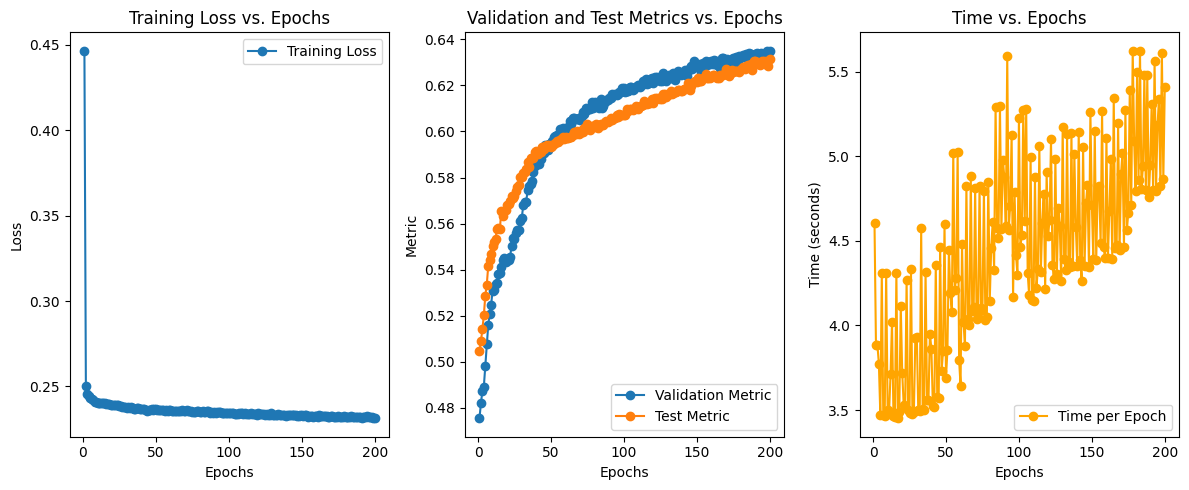

Best Validation Metric: 0.6350802776892885
Test Metric: 0.6307807797930923
2


100% 10/10 [00:00<00:00, 29.11it/s]


loss returned: 0.4861934959232353


100% 2/2 [00:00<00:00, 38.34it/s]
100% 2/2 [00:00<00:00, 35.48it/s]


Epoch: 001, Loss: 0.4862, Val Acc: {'rocauc': 0.6840074819922487}, Test Acc: {'rocauc': 0.6354124933226495}


100% 10/10 [00:00<00:00, 42.41it/s]


loss returned: 0.28691146731578526


100% 2/2 [00:00<00:00, 68.87it/s]
100% 2/2 [00:00<00:00, 65.51it/s]


Epoch: 002, Loss: 0.2869, Val Acc: {'rocauc': 0.6869182943365743}, Test Acc: {'rocauc': 0.6422158787393163}


100% 10/10 [00:00<00:00, 46.81it/s]


loss returned: 0.23847041820995288


100% 2/2 [00:00<00:00, 69.27it/s]
100% 2/2 [00:00<00:00, 70.83it/s]


Epoch: 003, Loss: 0.2385, Val Acc: {'rocauc': 0.687105584566708}, Test Acc: {'rocauc': 0.6451555822649573}


100% 10/10 [00:00<00:00, 47.98it/s]


loss returned: 0.23675597016837616


100% 2/2 [00:00<00:00, 61.36it/s]
100% 2/2 [00:00<00:00, 73.09it/s]


Epoch: 004, Loss: 0.2368, Val Acc: {'rocauc': 0.6932344710193012}, Test Acc: {'rocauc': 0.6478231837606838}


100% 10/10 [00:00<00:00, 48.07it/s]


loss returned: 0.23777248259321498


100% 2/2 [00:00<00:00, 57.77it/s]
100% 2/2 [00:00<00:00, 69.49it/s]


Epoch: 005, Loss: 0.2378, Val Acc: {'rocauc': 0.6975212294317341}, Test Acc: {'rocauc': 0.6482872596153846}


100% 10/10 [00:00<00:00, 47.33it/s]


loss returned: 0.23668652295965345


100% 2/2 [00:00<00:00, 62.19it/s]
100% 2/2 [00:00<00:00, 67.33it/s]


Epoch: 006, Loss: 0.2367, Val Acc: {'rocauc': 0.7021703066847464}, Test Acc: {'rocauc': 0.6491235977564103}


100% 10/10 [00:00<00:00, 47.44it/s]


loss returned: 0.23585493447516148


100% 2/2 [00:00<00:00, 62.43it/s]
100% 2/2 [00:00<00:00, 62.38it/s]


Epoch: 007, Loss: 0.2359, Val Acc: {'rocauc': 0.7052479732263928}, Test Acc: {'rocauc': 0.6497187166132479}


100% 10/10 [00:00<00:00, 50.33it/s]


loss returned: 0.235474755030179


100% 2/2 [00:00<00:00, 55.52it/s]
100% 2/2 [00:00<00:00, 68.27it/s]


Epoch: 008, Loss: 0.2355, Val Acc: {'rocauc': 0.7077536712731889}, Test Acc: {'rocauc': 0.6502069978632479}


100% 10/10 [00:00<00:00, 44.76it/s]


loss returned: 0.23535805039744978


100% 2/2 [00:00<00:00, 74.95it/s]
100% 2/2 [00:00<00:00, 72.09it/s]


Epoch: 009, Loss: 0.2354, Val Acc: {'rocauc': 0.7084783089543483}, Test Acc: {'rocauc': 0.6514798677884616}


100% 10/10 [00:00<00:00, 21.18it/s]


loss returned: 0.23533342065799046


100% 2/2 [00:00<00:00, 74.39it/s]
100% 2/2 [00:00<00:00, 72.50it/s]


Epoch: 010, Loss: 0.2353, Val Acc: {'rocauc': 0.7096263331506112}, Test Acc: {'rocauc': 0.6512144431089744}


100% 10/10 [00:00<00:00, 43.55it/s]


loss returned: 0.2349088226053091


100% 2/2 [00:00<00:00, 65.23it/s]
100% 2/2 [00:00<00:00, 76.78it/s]


Epoch: 011, Loss: 0.2349, Val Acc: {'rocauc': 0.7084213284863872}, Test Acc: {'rocauc': 0.6526584201388889}


100% 10/10 [00:00<00:00, 42.87it/s]


loss returned: 0.2346502003479973


100% 2/2 [00:00<00:00, 91.01it/s]
100% 2/2 [00:00<00:00, 67.68it/s]


Epoch: 012, Loss: 0.2347, Val Acc: {'rocauc': 0.7106868430416511}, Test Acc: {'rocauc': 0.6529605702457265}


100% 10/10 [00:00<00:00, 47.26it/s]


loss returned: 0.23460082009523023


100% 2/2 [00:00<00:00, 66.57it/s]
100% 2/2 [00:00<00:00, 64.35it/s]


Epoch: 013, Loss: 0.2346, Val Acc: {'rocauc': 0.71062986257369}, Test Acc: {'rocauc': 0.6539037459935897}


100% 10/10 [00:00<00:00, 46.67it/s]


loss returned: 0.23435925039368904


100% 2/2 [00:00<00:00, 66.04it/s]
100% 2/2 [00:00<00:00, 56.61it/s]


Epoch: 014, Loss: 0.2344, Val Acc: {'rocauc': 0.7125635921256359}, Test Acc: {'rocauc': 0.6578567374465811}


100% 10/10 [00:00<00:00, 44.39it/s]


loss returned: 0.23424831237155033


100% 2/2 [00:00<00:00, 77.59it/s]
100% 2/2 [00:00<00:00, 69.29it/s]


Epoch: 015, Loss: 0.2342, Val Acc: {'rocauc': 0.7136810824846369}, Test Acc: {'rocauc': 0.6591020633012821}


100% 10/10 [00:00<00:00, 45.08it/s]


loss returned: 0.23430352699039952


100% 2/2 [00:00<00:00, 61.18it/s]
100% 2/2 [00:00<00:00, 66.08it/s]


Epoch: 016, Loss: 0.2343, Val Acc: {'rocauc': 0.7149512420299471}, Test Acc: {'rocauc': 0.6601888020833333}


100% 10/10 [00:00<00:00, 44.20it/s]


loss returned: 0.23378579748777087


100% 2/2 [00:00<00:00, 78.62it/s]
100% 2/2 [00:00<00:00, 63.19it/s]


Epoch: 017, Loss: 0.2338, Val Acc: {'rocauc': 0.7167933700701076}, Test Acc: {'rocauc': 0.6582507011217948}


100% 10/10 [00:00<00:00, 42.06it/s]


loss returned: 0.2339822984790267


100% 2/2 [00:00<00:00, 95.80it/s]
100% 2/2 [00:00<00:00, 70.89it/s]


Epoch: 018, Loss: 0.2340, Val Acc: {'rocauc': 0.7144403412096207}, Test Acc: {'rocauc': 0.6594075520833333}


100% 10/10 [00:00<00:00, 44.24it/s]


loss returned: 0.23350518519196037


100% 2/2 [00:00<00:00, 69.57it/s]
100% 2/2 [00:00<00:00, 66.36it/s]


Epoch: 019, Loss: 0.2335, Val Acc: {'rocauc': 0.7130826673590875}, Test Acc: {'rocauc': 0.6582874265491452}


100% 10/10 [00:00<00:00, 43.73it/s]


loss returned: 0.2333561791316823


100% 2/2 [00:00<00:00, 83.32it/s]
100% 2/2 [00:00<00:00, 63.38it/s]


Epoch: 020, Loss: 0.2334, Val Acc: {'rocauc': 0.7127814161930315}, Test Acc: {'rocauc': 0.6589376335470085}


100% 10/10 [00:00<00:00, 42.06it/s]


loss returned: 0.2331752101815827


100% 2/2 [00:00<00:00, 82.76it/s]
100% 2/2 [00:00<00:00, 67.93it/s]


Epoch: 021, Loss: 0.2332, Val Acc: {'rocauc': 0.7132353365453967}, Test Acc: {'rocauc': 0.659072015224359}


100% 10/10 [00:00<00:00, 43.88it/s]


loss returned: 0.23266486731451713


100% 2/2 [00:00<00:00, 94.30it/s]
100% 2/2 [00:00<00:00, 64.93it/s]


Epoch: 022, Loss: 0.2327, Val Acc: {'rocauc': 0.7108212400103864}, Test Acc: {'rocauc': 0.6586204594017094}


100% 10/10 [00:00<00:00, 47.16it/s]


loss returned: 0.23279232445356707


100% 2/2 [00:00<00:00, 66.12it/s]
100% 2/2 [00:00<00:00, 63.63it/s]


Epoch: 023, Loss: 0.2328, Val Acc: {'rocauc': 0.7098258850004329}, Test Acc: {'rocauc': 0.6576622596153845}


100% 10/10 [00:00<00:00, 39.95it/s]


loss returned: 0.23256136710415645


100% 2/2 [00:00<00:00, 97.01it/s]
100% 2/2 [00:00<00:00, 55.54it/s]


Epoch: 024, Loss: 0.2326, Val Acc: {'rocauc': 0.7091623149937971}, Test Acc: {'rocauc': 0.6556874332264957}


100% 10/10 [00:00<00:00, 48.34it/s]


loss returned: 0.23230286541881448


100% 2/2 [00:00<00:00, 76.39it/s]
100% 2/2 [00:00<00:00, 76.85it/s]


Epoch: 025, Loss: 0.2323, Val Acc: {'rocauc': 0.7088305299904791}, Test Acc: {'rocauc': 0.6541950454059828}


100% 10/10 [00:00<00:00, 42.72it/s]


loss returned: 0.23223024647080423


100% 2/2 [00:00<00:00, 69.45it/s]
100% 2/2 [00:00<00:00, 62.40it/s]


Epoch: 026, Loss: 0.2322, Val Acc: {'rocauc': 0.7074728561399459}, Test Acc: {'rocauc': 0.6542559762286324}


100% 10/10 [00:00<00:00, 43.70it/s]


loss returned: 0.23167738793488785


100% 2/2 [00:00<00:00, 77.67it/s]
100% 2/2 [00:00<00:00, 72.74it/s]


Epoch: 027, Loss: 0.2317, Val Acc: {'rocauc': 0.7085292788244233}, Test Acc: {'rocauc': 0.6542651575854701}


100% 10/10 [00:00<00:00, 44.09it/s]


loss returned: 0.23172784212481462


100% 2/2 [00:00<00:00, 77.13it/s]
100% 2/2 [00:00<00:00, 66.22it/s]


Epoch: 028, Loss: 0.2317, Val Acc: {'rocauc': 0.7065080349672543}, Test Acc: {'rocauc': 0.6528704260149572}


100% 10/10 [00:00<00:00, 42.94it/s]


loss returned: 0.2316815579825796


100% 2/2 [00:00<00:00, 97.83it/s]
100% 2/2 [00:00<00:00, 70.03it/s]


Epoch: 029, Loss: 0.2317, Val Acc: {'rocauc': 0.7079878441668349}, Test Acc: {'rocauc': 0.6521534455128205}


100% 10/10 [00:00<00:00, 33.03it/s]


loss returned: 0.23177516842726223


100% 2/2 [00:00<00:00, 73.18it/s]
100% 2/2 [00:00<00:00, 72.11it/s]


Epoch: 030, Loss: 0.2318, Val Acc: {'rocauc': 0.7062678514757219}, Test Acc: {'rocauc': 0.6505208333333333}


100% 10/10 [00:00<00:00, 33.90it/s]


loss returned: 0.23099651468395682


100% 2/2 [00:00<00:00, 71.77it/s]
100% 2/2 [00:00<00:00, 73.95it/s]


Epoch: 031, Loss: 0.2310, Val Acc: {'rocauc': 0.7043076752930766}, Test Acc: {'rocauc': 0.6501302083333333}


100% 10/10 [00:00<00:00, 32.75it/s]


loss returned: 0.23045147860787057


100% 2/2 [00:00<00:00, 73.11it/s]
100% 2/2 [00:00<00:00, 70.62it/s]


Epoch: 032, Loss: 0.2305, Val Acc: {'rocauc': 0.7042771414558149}, Test Acc: {'rocauc': 0.6486712072649572}


100% 10/10 [00:00<00:00, 34.03it/s]


loss returned: 0.230593961568125


100% 2/2 [00:00<00:00, 70.66it/s]
100% 2/2 [00:00<00:00, 71.10it/s]


Epoch: 033, Loss: 0.2306, Val Acc: {'rocauc': 0.7043382091303385}, Test Acc: {'rocauc': 0.6454084869123932}


100% 10/10 [00:00<00:00, 36.39it/s]


loss returned: 0.23009886091084525


100% 2/2 [00:00<00:00, 71.75it/s]
100% 2/2 [00:00<00:00, 66.47it/s]


Epoch: 034, Loss: 0.2301, Val Acc: {'rocauc': 0.7026487502764875}, Test Acc: {'rocauc': 0.6431865985576923}


100% 10/10 [00:00<00:00, 35.38it/s]


loss returned: 0.23003487745702114


100% 2/2 [00:00<00:00, 69.48it/s]
100% 2/2 [00:00<00:00, 74.31it/s]


Epoch: 035, Loss: 0.2300, Val Acc: {'rocauc': 0.7001430522296914}, Test Acc: {'rocauc': 0.6392861912393162}


100% 10/10 [00:00<00:00, 33.34it/s]


loss returned: 0.22988315475481633


100% 2/2 [00:00<00:00, 71.58it/s]
100% 2/2 [00:00<00:00, 69.61it/s]


Epoch: 036, Loss: 0.2299, Val Acc: {'rocauc': 0.6968557360337747}, Test Acc: {'rocauc': 0.6380684094551282}


100% 10/10 [00:00<00:00, 37.92it/s]


loss returned: 0.22925391137145718


100% 2/2 [00:00<00:00, 75.51it/s]
100% 2/2 [00:00<00:00, 74.21it/s]


Epoch: 037, Loss: 0.2293, Val Acc: {'rocauc': 0.693686467980343}, Test Acc: {'rocauc': 0.6361486712072649}


100% 10/10 [00:00<00:00, 36.66it/s]


loss returned: 0.229222273140212


100% 2/2 [00:00<00:00, 72.28it/s]
100% 2/2 [00:00<00:00, 71.09it/s]


Epoch: 038, Loss: 0.2292, Val Acc: {'rocauc': 0.6927521806449132}, Test Acc: {'rocauc': 0.6333650507478632}


100% 10/10 [00:00<00:00, 31.87it/s]


loss returned: 0.22915359821791975


100% 2/2 [00:00<00:00, 52.60it/s]
100% 2/2 [00:00<00:00, 43.48it/s]


Epoch: 039, Loss: 0.2292, Val Acc: {'rocauc': 0.6934157506515488}, Test Acc: {'rocauc': 0.6320679754273504}


100% 10/10 [00:00<00:00, 31.91it/s]


loss returned: 0.22897220175211758


100% 2/2 [00:00<00:00, 49.56it/s]
100% 2/2 [00:00<00:00, 53.44it/s]


Epoch: 040, Loss: 0.2290, Val Acc: {'rocauc': 0.6888888087475837}, Test Acc: {'rocauc': 0.628762686965812}


100% 10/10 [00:00<00:00, 32.41it/s]


loss returned: 0.22928472079027518


100% 2/2 [00:00<00:00, 60.73it/s]
100% 2/2 [00:00<00:00, 45.63it/s]


Epoch: 041, Loss: 0.2293, Val Acc: {'rocauc': 0.6756703018762682}, Test Acc: {'rocauc': 0.6190079126602565}


100% 10/10 [00:00<00:00, 33.82it/s]


loss returned: 0.22822642316261052


100% 2/2 [00:00<00:00, 66.81it/s]
100% 2/2 [00:00<00:00, 71.35it/s]


Epoch: 042, Loss: 0.2282, Val Acc: {'rocauc': 0.6771195772385871}, Test Acc: {'rocauc': 0.6200579260149572}


100% 10/10 [00:00<00:00, 42.53it/s]


loss returned: 0.22766026650113033


100% 2/2 [00:00<00:00, 77.14it/s]
100% 2/2 [00:00<00:00, 73.70it/s]


Epoch: 043, Loss: 0.2277, Val Acc: {'rocauc': 0.6663762345768058}, Test Acc: {'rocauc': 0.606939436431624}


100% 10/10 [00:00<00:00, 44.46it/s]


loss returned: 0.2277360335434018


100% 2/2 [00:00<00:00, 62.70it/s]
100% 2/2 [00:00<00:00, 63.83it/s]


Epoch: 044, Loss: 0.2277, Val Acc: {'rocauc': 0.6639316042045333}, Test Acc: {'rocauc': 0.6040247729700855}


100% 10/10 [00:00<00:00, 39.46it/s]


loss returned: 0.2272265060386044


100% 2/2 [00:00<00:00, 86.19it/s]
100% 2/2 [00:00<00:00, 67.51it/s]


Epoch: 045, Loss: 0.2272, Val Acc: {'rocauc': 0.6626044641912621}, Test Acc: {'rocauc': 0.60240718482906}


100% 10/10 [00:00<00:00, 43.34it/s]


loss returned: 0.2263351271432098


100% 2/2 [00:00<00:00, 89.89it/s]
100% 2/2 [00:00<00:00, 59.71it/s]


Epoch: 046, Loss: 0.2263, Val Acc: {'rocauc': 0.6671314060952271}, Test Acc: {'rocauc': 0.6043177417200855}


100% 10/10 [00:00<00:00, 42.92it/s]


loss returned: 0.22703269071037946


100% 2/2 [00:00<00:00, 80.47it/s]
100% 2/2 [00:00<00:00, 54.73it/s]


Epoch: 047, Loss: 0.2270, Val Acc: {'rocauc': 0.6644465922314224}, Test Acc: {'rocauc': 0.6039913862179488}


100% 10/10 [00:00<00:00, 44.53it/s]


loss returned: 0.2265480221529112


100% 2/2 [00:00<00:00, 72.05it/s]
100% 2/2 [00:00<00:00, 63.32it/s]


Epoch: 048, Loss: 0.2265, Val Acc: {'rocauc': 0.6617007106930941}, Test Acc: {'rocauc': 0.6017786792200855}


100% 10/10 [00:00<00:00, 43.29it/s]


loss returned: 0.2265734007104184


100% 2/2 [00:00<00:00, 88.32it/s]
100% 2/2 [00:00<00:00, 60.37it/s]


Epoch: 049, Loss: 0.2266, Val Acc: {'rocauc': 0.6627876672148332}, Test Acc: {'rocauc': 0.6015650040064103}


100% 10/10 [00:00<00:00, 46.36it/s]


loss returned: 0.22644465576280082


100% 2/2 [00:00<00:00, 70.25it/s]
100% 2/2 [00:00<00:00, 69.53it/s]


Epoch: 050, Loss: 0.2264, Val Acc: {'rocauc': 0.6635123048959926}, Test Acc: {'rocauc': 0.6013546674679486}


100% 10/10 [00:00<00:00, 41.24it/s]


loss returned: 0.22618443081683773


100% 2/2 [00:00<00:00, 71.86it/s]
100% 2/2 [00:00<00:00, 67.37it/s]


Epoch: 051, Loss: 0.2262, Val Acc: {'rocauc': 0.6645687275804699}, Test Acc: {'rocauc': 0.6020140558226496}


100% 10/10 [00:00<00:00, 43.74it/s]


loss returned: 0.22595522791828573


100% 2/2 [00:00<00:00, 95.24it/s]
100% 2/2 [00:00<00:00, 62.91it/s]


Epoch: 052, Loss: 0.2260, Val Acc: {'rocauc': 0.6663192541088447}, Test Acc: {'rocauc': 0.602004874465812}


100% 10/10 [00:00<00:00, 48.70it/s]


loss returned: 0.22607498978730686


100% 2/2 [00:00<00:00, 74.92it/s]
100% 2/2 [00:00<00:00, 56.85it/s]


Epoch: 053, Loss: 0.2261, Val Acc: {'rocauc': 0.6663803217833684}, Test Acc: {'rocauc': 0.60107421875}


100% 10/10 [00:00<00:00, 42.45it/s]


loss returned: 0.22595626447636832


100% 2/2 [00:00<00:00, 69.56it/s]
100% 2/2 [00:00<00:00, 73.13it/s]


Epoch: 054, Loss: 0.2260, Val Acc: {'rocauc': 0.6690346018099113}, Test Acc: {'rocauc': 0.6029021434294872}


100% 10/10 [00:00<00:00, 41.71it/s]


loss returned: 0.22561850370389744


100% 2/2 [00:00<00:00, 88.53it/s]
100% 2/2 [00:00<00:00, 70.83it/s]


Epoch: 055, Loss: 0.2256, Val Acc: {'rocauc': 0.6674367444678457}, Test Acc: {'rocauc': 0.5992429553952991}


100% 10/10 [00:00<00:00, 43.94it/s]


loss returned: 0.22638767586735525


100% 2/2 [00:00<00:00, 79.51it/s]
100% 2/2 [00:00<00:00, 69.74it/s]


Epoch: 056, Loss: 0.2264, Val Acc: {'rocauc': 0.6674672783051074}, Test Acc: {'rocauc': 0.5987029246794872}


100% 10/10 [00:00<00:00, 41.34it/s]


loss returned: 0.22544210853968305


100% 2/2 [00:00<00:00, 104.57it/s]
100% 2/2 [00:00<00:00, 68.66it/s]


Epoch: 057, Loss: 0.2254, Val Acc: {'rocauc': 0.6671049594645279}, Test Acc: {'rocauc': 0.5986753806089744}


100% 10/10 [00:00<00:00, 39.57it/s]


loss returned: 0.2256534143235096


100% 2/2 [00:00<00:00, 90.54it/s]
100% 2/2 [00:00<00:00, 63.67it/s]


Epoch: 058, Loss: 0.2257, Val Acc: {'rocauc': 0.6698203071655944}, Test Acc: {'rocauc': 0.6000792935363248}


100% 10/10 [00:00<00:00, 44.13it/s]


loss returned: 0.22586394640775578


100% 2/2 [00:00<00:00, 81.12it/s]
100% 2/2 [00:00<00:00, 74.31it/s]


Epoch: 059, Loss: 0.2259, Val Acc: {'rocauc': 0.6718720848600251}, Test Acc: {'rocauc': 0.601608406784188}


100% 10/10 [00:00<00:00, 41.15it/s]


loss returned: 0.22614283539247554


100% 2/2 [00:00<00:00, 101.19it/s]
100% 2/2 [00:00<00:00, 61.91it/s]


Epoch: 060, Loss: 0.2261, Val Acc: {'rocauc': 0.6708461960128098}, Test Acc: {'rocauc': 0.5984041132478632}


100% 10/10 [00:00<00:00, 44.76it/s]


loss returned: 0.22500063848636798


100% 2/2 [00:00<00:00, 97.31it/s]
100% 2/2 [00:00<00:00, 66.17it/s]


Epoch: 061, Loss: 0.2250, Val Acc: {'rocauc': 0.6773638479366819}, Test Acc: {'rocauc': 0.6027894631410255}


100% 10/10 [00:00<00:00, 43.68it/s]


loss returned: 0.22544713137918967


100% 2/2 [00:00<00:00, 99.59it/s]
100% 2/2 [00:00<00:00, 71.25it/s]


Epoch: 062, Loss: 0.2254, Val Acc: {'rocauc': 0.6749192175644095}, Test Acc: {'rocauc': 0.6017761752136752}


100% 10/10 [00:00<00:00, 42.76it/s]


loss returned: 0.22505001697269766


100% 2/2 [00:00<00:00, 85.67it/s]
100% 2/2 [00:00<00:00, 65.74it/s]


Epoch: 063, Loss: 0.2251, Val Acc: {'rocauc': 0.6767002779300462}, Test Acc: {'rocauc': 0.6012970753205129}


100% 10/10 [00:00<00:00, 39.73it/s]


loss returned: 0.22506326935384155


100% 2/2 [00:00<00:00, 84.81it/s]
100% 2/2 [00:00<00:00, 68.60it/s]


Epoch: 064, Loss: 0.2251, Val Acc: {'rocauc': 0.6786909879499534}, Test Acc: {'rocauc': 0.6017761752136752}


100% 10/10 [00:00<00:00, 44.34it/s]


loss returned: 0.22522871529369612


100% 2/2 [00:00<00:00, 90.63it/s]
100% 2/2 [00:00<00:00, 75.53it/s]


Epoch: 065, Loss: 0.2252, Val Acc: {'rocauc': 0.6827640095015531}, Test Acc: {'rocauc': 0.606461171207265}


100% 10/10 [00:00<00:00, 43.61it/s]


loss returned: 0.2248072921346548


100% 2/2 [00:00<00:00, 86.65it/s]
100% 2/2 [00:00<00:00, 67.42it/s]


Epoch: 066, Loss: 0.2248, Val Acc: {'rocauc': 0.6810745506477021}, Test Acc: {'rocauc': 0.6036533453525641}


100% 10/10 [00:00<00:00, 41.26it/s]


loss returned: 0.22455078648572044


100% 2/2 [00:00<00:00, 79.74it/s]
100% 2/2 [00:00<00:00, 71.51it/s]


Epoch: 067, Loss: 0.2246, Val Acc: {'rocauc': 0.6821615071694411}, Test Acc: {'rocauc': 0.6038394764957266}


100% 10/10 [00:00<00:00, 45.37it/s]


loss returned: 0.2247786565946382


100% 2/2 [00:00<00:00, 74.39it/s]
100% 2/2 [00:00<00:00, 75.95it/s]


Epoch: 068, Loss: 0.2248, Val Acc: {'rocauc': 0.6845756037044517}, Test Acc: {'rocauc': 0.606409421741453}


100% 10/10 [00:00<00:00, 43.45it/s]


loss returned: 0.22488456728547232


100% 2/2 [00:00<00:00, 75.83it/s]
100% 2/2 [00:00<00:00, 71.69it/s]


Epoch: 069, Loss: 0.2249, Val Acc: {'rocauc': 0.6842438187011338}, Test Acc: {'rocauc': 0.6043828458867522}


100% 10/10 [00:00<00:00, 41.65it/s]


loss returned: 0.22413670862760712


100% 2/2 [00:00<00:00, 95.35it/s]
100% 2/2 [00:00<00:00, 55.13it/s]


Epoch: 070, Loss: 0.2241, Val Acc: {'rocauc': 0.6753731379167749}, Test Acc: {'rocauc': 0.5970277443910257}


100% 10/10 [00:00<00:00, 42.77it/s]


loss returned: 0.22451610882134887


100% 2/2 [00:00<00:00, 92.07it/s]
100% 2/2 [00:00<00:00, 71.57it/s]


Epoch: 071, Loss: 0.2245, Val Acc: {'rocauc': 0.6743167152322975}, Test Acc: {'rocauc': 0.5960937500000001}


100% 10/10 [00:00<00:00, 43.37it/s]


loss returned: 0.22424532020122293


100% 2/2 [00:00<00:00, 84.00it/s]
100% 2/2 [00:00<00:00, 67.40it/s]


Epoch: 072, Loss: 0.2242, Val Acc: {'rocauc': 0.6750108190761952}, Test Acc: {'rocauc': 0.5969484508547008}


100% 10/10 [00:00<00:00, 31.77it/s]


loss returned: 0.2244775916412662


100% 2/2 [00:00<00:00, 51.33it/s]
100% 2/2 [00:00<00:00, 65.47it/s]


Epoch: 073, Loss: 0.2245, Val Acc: {'rocauc': 0.6771847321196733}, Test Acc: {'rocauc': 0.597018563034188}


100% 10/10 [00:00<00:00, 32.71it/s]


loss returned: 0.22425103083467401


100% 2/2 [00:00<00:00, 56.86it/s]
100% 2/2 [00:00<00:00, 63.49it/s]


Epoch: 074, Loss: 0.2243, Val Acc: {'rocauc': 0.6764906282757758}, Test Acc: {'rocauc': 0.5969117254273504}


100% 10/10 [00:00<00:00, 33.89it/s]


loss returned: 0.22475820156500362


100% 2/2 [00:00<00:00, 54.86it/s]
100% 2/2 [00:00<00:00, 54.48it/s]


Epoch: 075, Loss: 0.2248, Val Acc: {'rocauc': 0.6782106209668888}, Test Acc: {'rocauc': 0.597995125534188}


100% 10/10 [00:00<00:00, 33.74it/s]


loss returned: 0.2243610232639474


100% 2/2 [00:00<00:00, 63.34it/s]
100% 2/2 [00:00<00:00, 61.34it/s]


Epoch: 076, Loss: 0.2244, Val Acc: {'rocauc': 0.6795988286546839}, Test Acc: {'rocauc': 0.5959593683226496}


100% 10/10 [00:00<00:00, 35.73it/s]


loss returned: 0.22369575419736856


100% 2/2 [00:00<00:00, 65.64it/s]
100% 2/2 [00:00<00:00, 75.07it/s]


Epoch: 077, Loss: 0.2237, Val Acc: {'rocauc': 0.6839731013723397}, Test Acc: {'rocauc': 0.5999298878205128}


100% 10/10 [00:00<00:00, 30.37it/s]


loss returned: 0.22401787816317378


100% 2/2 [00:00<00:00, 66.96it/s]
100% 2/2 [00:00<00:00, 75.96it/s]


Epoch: 078, Loss: 0.2240, Val Acc: {'rocauc': 0.6860859467412943}, Test Acc: {'rocauc': 0.6015199318910257}


100% 10/10 [00:00<00:00, 32.42it/s]


loss returned: 0.22377150734787166


100% 2/2 [00:00<00:00, 76.99it/s]
100% 2/2 [00:00<00:00, 76.64it/s]


Epoch: 079, Loss: 0.2238, Val Acc: {'rocauc': 0.6868105844224537}, Test Acc: {'rocauc': 0.5992003872863247}


100% 10/10 [00:00<00:00, 35.95it/s]


loss returned: 0.2236757138389132


100% 2/2 [00:00<00:00, 61.52it/s]
100% 2/2 [00:00<00:00, 68.40it/s]


Epoch: 080, Loss: 0.2237, Val Acc: {'rocauc': 0.6898882509641}, Test Acc: {'rocauc': 0.6019990317841881}


100% 10/10 [00:00<00:00, 32.72it/s]


loss returned: 0.22355887799773752


100% 2/2 [00:00<00:00, 61.24it/s]
100% 2/2 [00:00<00:00, 58.98it/s]


Epoch: 081, Loss: 0.2236, Val Acc: {'rocauc': 0.6923634151736341}, Test Acc: {'rocauc': 0.6038853832799145}


100% 10/10 [00:00<00:00, 32.90it/s]


loss returned: 0.22446636394751365


100% 2/2 [00:00<00:00, 55.69it/s]
100% 2/2 [00:00<00:00, 63.88it/s]


Epoch: 082, Loss: 0.2245, Val Acc: {'rocauc': 0.6942055432137946}, Test Acc: {'rocauc': 0.6084209735576923}


100% 10/10 [00:00<00:00, 32.88it/s]


loss returned: 0.22378899317288378


100% 2/2 [00:00<00:00, 51.83it/s]
100% 2/2 [00:00<00:00, 66.37it/s]


Epoch: 083, Loss: 0.2238, Val Acc: {'rocauc': 0.6962573209082255}, Test Acc: {'rocauc': 0.6078684228098291}


100% 10/10 [00:00<00:00, 33.65it/s]


loss returned: 0.2231684041088865


100% 2/2 [00:00<00:00, 73.07it/s]
100% 2/2 [00:00<00:00, 66.92it/s]


Epoch: 084, Loss: 0.2232, Val Acc: {'rocauc': 0.6978857120875528}, Test Acc: {'rocauc': 0.6061256343482906}


100% 10/10 [00:00<00:00, 43.54it/s]


loss returned: 0.22355070732893528


100% 2/2 [00:00<00:00, 89.36it/s]
100% 2/2 [00:00<00:00, 61.70it/s]


Epoch: 085, Loss: 0.2236, Val Acc: {'rocauc': 0.6982480309281325}, Test Acc: {'rocauc': 0.6071389222756409}


100% 10/10 [00:00<00:00, 43.21it/s]


loss returned: 0.22442450886000828


100% 2/2 [00:00<00:00, 69.81it/s]
100% 2/2 [00:00<00:00, 63.93it/s]


Epoch: 086, Loss: 0.2244, Val Acc: {'rocauc': 0.6982480309281325}, Test Acc: {'rocauc': 0.6066748464209402}


100% 10/10 [00:00<00:00, 43.37it/s]


loss returned: 0.2236469004438854


100% 2/2 [00:00<00:00, 92.62it/s]
100% 2/2 [00:00<00:00, 72.17it/s]


Epoch: 087, Loss: 0.2236, Val Acc: {'rocauc': 0.6978857120875528}, Test Acc: {'rocauc': 0.6029513888888889}


100% 10/10 [00:00<00:00, 44.66it/s]


loss returned: 0.2241396287252699


100% 2/2 [00:00<00:00, 64.62it/s]
100% 2/2 [00:00<00:00, 67.87it/s]


Epoch: 088, Loss: 0.2241, Val Acc: {'rocauc': 0.6947469778713828}, Test Acc: {'rocauc': 0.6011660323183761}


100% 10/10 [00:00<00:00, 40.65it/s]


loss returned: 0.2242563048805048


100% 2/2 [00:00<00:00, 93.07it/s]
100% 2/2 [00:00<00:00, 55.78it/s]


Epoch: 089, Loss: 0.2243, Val Acc: {'rocauc': 0.6950482290374388}, Test Acc: {'rocauc': 0.601263688568376}


100% 10/10 [00:00<00:00, 43.34it/s]


loss returned: 0.2246629871194591


100% 2/2 [00:00<00:00, 88.32it/s]
100% 2/2 [00:00<00:00, 73.65it/s]


Epoch: 090, Loss: 0.2247, Val Acc: {'rocauc': 0.6999680236192454}, Test Acc: {'rocauc': 0.6075721153846154}


100% 10/10 [00:00<00:00, 43.45it/s]


loss returned: 0.22323901290160736


100% 2/2 [00:00<00:00, 93.61it/s]
100% 2/2 [00:00<00:00, 73.43it/s]


Epoch: 091, Loss: 0.2232, Val Acc: {'rocauc': 0.6985187482569266}, Test Acc: {'rocauc': 0.603412126068376}


100% 10/10 [00:00<00:00, 40.44it/s]


loss returned: 0.22363417829677879


100% 2/2 [00:00<00:00, 89.09it/s]
100% 2/2 [00:00<00:00, 67.71it/s]


Epoch: 092, Loss: 0.2236, Val Acc: {'rocauc': 0.7010244463037227}, Test Acc: {'rocauc': 0.6083441840277777}


100% 10/10 [00:00<00:00, 40.02it/s]


loss returned: 0.22307088549716506


100% 2/2 [00:00<00:00, 75.44it/s]
100% 2/2 [00:00<00:00, 69.84it/s]


Epoch: 093, Loss: 0.2231, Val Acc: {'rocauc': 0.7037397940047891}, Test Acc: {'rocauc': 0.6124799679487178}


100% 10/10 [00:00<00:00, 44.47it/s]


loss returned: 0.22295119885314227


100% 2/2 [00:00<00:00, 102.73it/s]
100% 2/2 [00:00<00:00, 61.48it/s]


Epoch: 094, Loss: 0.2230, Val Acc: {'rocauc': 0.7041021128453688}, Test Acc: {'rocauc': 0.6141251001602565}


100% 10/10 [00:00<00:00, 42.43it/s]


loss returned: 0.22272634677822362


100% 2/2 [00:00<00:00, 92.96it/s]
100% 2/2 [00:00<00:00, 76.93it/s]


Epoch: 095, Loss: 0.2227, Val Acc: {'rocauc': 0.7044949655232104}, Test Acc: {'rocauc': 0.612577624198718}


100% 10/10 [00:00<00:00, 41.30it/s]


loss returned: 0.22305360428869067


100% 2/2 [00:00<00:00, 104.23it/s]
100% 2/2 [00:00<00:00, 55.22it/s]


Epoch: 096, Loss: 0.2231, Val Acc: {'rocauc': 0.7024431878287797}, Test Acc: {'rocauc': 0.610602797809829}


100% 10/10 [00:00<00:00, 44.65it/s]


loss returned: 0.22279665383820207


100% 2/2 [00:00<00:00, 80.51it/s]
100% 2/2 [00:00<00:00, 60.86it/s]


Epoch: 097, Loss: 0.2228, Val Acc: {'rocauc': 0.7048572843637901}, Test Acc: {'rocauc': 0.6112070980235043}


100% 10/10 [00:00<00:00, 43.07it/s]


loss returned: 0.22245863978384312


100% 2/2 [00:00<00:00, 102.80it/s]
100% 2/2 [00:00<00:00, 74.32it/s]


Epoch: 098, Loss: 0.2225, Val Acc: {'rocauc': 0.7042547820316782}, Test Acc: {'rocauc': 0.6104166666666666}


100% 10/10 [00:00<00:00, 41.31it/s]


loss returned: 0.2228746639783861


100% 2/2 [00:00<00:00, 81.58it/s]
100% 2/2 [00:00<00:00, 71.97it/s]


Epoch: 099, Loss: 0.2229, Val Acc: {'rocauc': 0.7042547820316782}, Test Acc: {'rocauc': 0.6116436298076924}


100% 10/10 [00:00<00:00, 46.45it/s]


loss returned: 0.22350994625604323


100% 2/2 [00:00<00:00, 66.98it/s]
100% 2/2 [00:00<00:00, 74.10it/s]


Epoch: 100, Loss: 0.2235, Val Acc: {'rocauc': 0.7062454920515853}, Test Acc: {'rocauc': 0.6148546006944444}


100% 10/10 [00:00<00:00, 42.48it/s]


loss returned: 0.22227052230132424


100% 2/2 [00:00<00:00, 69.06it/s]
100% 2/2 [00:00<00:00, 69.07it/s]


Epoch: 101, Loss: 0.2223, Val Acc: {'rocauc': 0.7091135089389612}, Test Acc: {'rocauc': 0.611332298344017}


100% 10/10 [00:00<00:00, 42.09it/s]


loss returned: 0.22312543309663535


100% 2/2 [00:00<00:00, 89.01it/s]
100% 2/2 [00:00<00:00, 76.97it/s]


Epoch: 102, Loss: 0.2231, Val Acc: {'rocauc': 0.7101393977861765}, Test Acc: {'rocauc': 0.613404780982906}


100% 10/10 [00:00<00:00, 41.13it/s]


loss returned: 0.22245868935764693


100% 2/2 [00:00<00:00, 101.18it/s]
100% 2/2 [00:00<00:00, 63.23it/s]


Epoch: 103, Loss: 0.2225, Val Acc: {'rocauc': 0.7135793831684025}, Test Acc: {'rocauc': 0.6185688768696582}


100% 10/10 [00:00<00:00, 41.65it/s]


loss returned: 0.22348981999826067


100% 2/2 [00:00<00:00, 77.19it/s]
100% 2/2 [00:00<00:00, 68.13it/s]


Epoch: 104, Loss: 0.2235, Val Acc: {'rocauc': 0.7146358058528798}, Test Acc: {'rocauc': 0.6187641893696582}


100% 10/10 [00:00<00:00, 41.78it/s]


loss returned: 0.2231849221911701


100% 2/2 [00:00<00:00, 85.26it/s]
100% 2/2 [00:00<00:00, 63.80it/s]


Epoch: 105, Loss: 0.2232, Val Acc: {'rocauc': 0.7152993758595154}, Test Acc: {'rocauc': 0.6170764890491452}


100% 10/10 [00:00<00:00, 41.78it/s]


loss returned: 0.2227414953668273


100% 2/2 [00:00<00:00, 82.19it/s]
100% 2/2 [00:00<00:00, 58.10it/s]


Epoch: 106, Loss: 0.2227, Val Acc: {'rocauc': 0.7156311608628333}, Test Acc: {'rocauc': 0.6188985710470085}


100% 10/10 [00:00<00:00, 39.26it/s]


loss returned: 0.2226920808451747


100% 2/2 [00:00<00:00, 82.97it/s]
100% 2/2 [00:00<00:00, 76.58it/s]


Epoch: 107, Loss: 0.2227, Val Acc: {'rocauc': 0.7177440062317879}, Test Acc: {'rocauc': 0.6177692641559829}


100% 10/10 [00:00<00:00, 42.05it/s]


loss returned: 0.22252577494050768


100% 2/2 [00:00<00:00, 67.63it/s]
100% 2/2 [00:00<00:00, 78.05it/s]


Epoch: 108, Loss: 0.2225, Val Acc: {'rocauc': 0.7163557985439928}, Test Acc: {'rocauc': 0.6198233840811966}


100% 10/10 [00:00<00:00, 44.26it/s]


loss returned: 0.22251180663490377


100% 2/2 [00:00<00:00, 91.84it/s]
100% 2/2 [00:00<00:00, 74.15it/s]


Epoch: 109, Loss: 0.2225, Val Acc: {'rocauc': 0.7160545473779367}, Test Acc: {'rocauc': 0.6166858640491453}


100% 10/10 [00:00<00:00, 42.72it/s]


loss returned: 0.22236913783281764


100% 2/2 [00:00<00:00, 77.32it/s]
100% 2/2 [00:00<00:00, 60.61it/s]


Epoch: 110, Loss: 0.2224, Val Acc: {'rocauc': 0.7149981246934594}, Test Acc: {'rocauc': 0.6171132144764957}


100% 10/10 [00:00<00:00, 41.86it/s]


loss returned: 0.2223502988284367


100% 2/2 [00:00<00:00, 87.24it/s]
100% 2/2 [00:00<00:00, 56.43it/s]


Epoch: 111, Loss: 0.2224, Val Acc: {'rocauc': 0.7149370570189357}, Test Acc: {'rocauc': 0.6134231436965811}


100% 10/10 [00:00<00:00, 40.78it/s]


loss returned: 0.22354781811869215


100% 2/2 [00:00<00:00, 70.86it/s]
100% 2/2 [00:00<00:00, 77.55it/s]


Epoch: 112, Loss: 0.2235, Val Acc: {'rocauc': 0.7167181173845725}, Test Acc: {'rocauc': 0.6157610510149572}


100% 10/10 [00:00<00:00, 43.31it/s]


loss returned: 0.2229918327803939


100% 2/2 [00:00<00:00, 85.35it/s]
100% 2/2 [00:00<00:00, 73.33it/s]


Epoch: 113, Loss: 0.2230, Val Acc: {'rocauc': 0.7101088639489146}, Test Acc: {'rocauc': 0.6127579126602565}


100% 10/10 [00:00<00:00, 41.16it/s]


loss returned: 0.22470703215088308


100% 2/2 [00:00<00:00, 85.30it/s]
100% 2/2 [00:00<00:00, 61.46it/s]


Epoch: 114, Loss: 0.2247, Val Acc: {'rocauc': 0.7149370570189357}, Test Acc: {'rocauc': 0.6111311431623931}


100% 10/10 [00:00<00:00, 32.06it/s]


loss returned: 0.22202109561241046


100% 2/2 [00:00<00:00, 68.75it/s]
100% 2/2 [00:00<00:00, 65.47it/s]


Epoch: 115, Loss: 0.2220, Val Acc: {'rocauc': 0.7163252647067309}, Test Acc: {'rocauc': 0.6194936899038461}


100% 10/10 [00:00<00:00, 29.63it/s]


loss returned: 0.22272962362053633


100% 2/2 [00:00<00:00, 61.10it/s]
100% 2/2 [00:00<00:00, 59.37it/s]


Epoch: 116, Loss: 0.2227, Val Acc: {'rocauc': 0.7174427550657319}, Test Acc: {'rocauc': 0.6170247395833333}


100% 10/10 [00:00<00:00, 37.64it/s]


loss returned: 0.22261526113238808


100% 2/2 [00:00<00:00, 48.76it/s]
100% 2/2 [00:00<00:00, 71.51it/s]


Epoch: 117, Loss: 0.2226, Val Acc: {'rocauc': 0.7184686439129473}, Test Acc: {'rocauc': 0.6157276642628204}


100% 10/10 [00:00<00:00, 36.97it/s]


loss returned: 0.22332873831958108


100% 2/2 [00:00<00:00, 74.67it/s]
100% 2/2 [00:00<00:00, 70.61it/s]


Epoch: 118, Loss: 0.2233, Val Acc: {'rocauc': 0.7204898877701162}, Test Acc: {'rocauc': 0.6210870726495725}


100% 10/10 [00:00<00:00, 34.42it/s]


loss returned: 0.22307795201641942


100% 2/2 [00:00<00:00, 69.35it/s]
100% 2/2 [00:00<00:00, 71.10it/s]


Epoch: 119, Loss: 0.2231, Val Acc: {'rocauc': 0.7252875470028755}, Test Acc: {'rocauc': 0.6205011351495726}


100% 10/10 [00:00<00:00, 33.89it/s]


loss returned: 0.22321326872941097


100% 2/2 [00:00<00:00, 70.96it/s]
100% 2/2 [00:00<00:00, 75.35it/s]


Epoch: 120, Loss: 0.2232, Val Acc: {'rocauc': 0.7245934431589779}, Test Acc: {'rocauc': 0.6210870726495725}


100% 10/10 [00:00<00:00, 36.20it/s]


loss returned: 0.2228845268689809


100% 2/2 [00:00<00:00, 71.83it/s]
100% 2/2 [00:00<00:00, 76.77it/s]


Epoch: 121, Loss: 0.2229, Val Acc: {'rocauc': 0.7256498658434553}, Test Acc: {'rocauc': 0.6167501335470085}


100% 10/10 [00:00<00:00, 32.17it/s]


loss returned: 0.22228209302144775


100% 2/2 [00:00<00:00, 47.75it/s]
100% 2/2 [00:00<00:00, 49.18it/s]


Epoch: 122, Loss: 0.2223, Val Acc: {'rocauc': 0.7187393612417414}, Test Acc: {'rocauc': 0.6169821714743589}


100% 10/10 [00:00<00:00, 31.53it/s]


loss returned: 0.22217805994001108


100% 2/2 [00:00<00:00, 57.63it/s]
100% 2/2 [00:00<00:00, 55.00it/s]


Epoch: 123, Loss: 0.2222, Val Acc: {'rocauc': 0.719433465085639}, Test Acc: {'rocauc': 0.6189110910790598}


100% 10/10 [00:00<00:00, 35.91it/s]


loss returned: 0.221836592412217


100% 2/2 [00:00<00:00, 74.03it/s]
100% 2/2 [00:00<00:00, 68.71it/s]


Epoch: 124, Loss: 0.2218, Val Acc: {'rocauc': 0.7214852427800698}, Test Acc: {'rocauc': 0.6165272769764957}


100% 10/10 [00:00<00:00, 34.56it/s]


loss returned: 0.2227569535614372


100% 2/2 [00:00<00:00, 71.56it/s]
100% 2/2 [00:00<00:00, 63.08it/s]


Epoch: 125, Loss: 0.2228, Val Acc: {'rocauc': 0.722873450467865}, Test Acc: {'rocauc': 0.6174245459401709}


100% 10/10 [00:00<00:00, 31.42it/s]


loss returned: 0.2233926766913993


100% 2/2 [00:00<00:00, 59.06it/s]
100% 2/2 [00:00<00:00, 66.23it/s]


Epoch: 126, Loss: 0.2234, Val Acc: {'rocauc': 0.7266757546906706}, Test Acc: {'rocauc': 0.6223140357905983}


100% 10/10 [00:00<00:00, 33.26it/s]


loss returned: 0.2221235236835924


100% 2/2 [00:00<00:00, 60.20it/s]
100% 2/2 [00:00<00:00, 71.43it/s]


Epoch: 127, Loss: 0.2221, Val Acc: {'rocauc': 0.7270075396939883}, Test Acc: {'rocauc': 0.6223232171474358}


100% 10/10 [00:00<00:00, 36.06it/s]


loss returned: 0.2219187278524483


100% 2/2 [00:00<00:00, 70.92it/s]
100% 2/2 [00:00<00:00, 65.56it/s]


Epoch: 128, Loss: 0.2219, Val Acc: {'rocauc': 0.7273393246973063}, Test Acc: {'rocauc': 0.6233089610042735}


100% 10/10 [00:00<00:00, 42.59it/s]


loss returned: 0.2223137044659315


100% 2/2 [00:00<00:00, 106.10it/s]
100% 2/2 [00:00<00:00, 64.69it/s]


Epoch: 129, Loss: 0.2223, Val Acc: {'rocauc': 0.7270075396939883}, Test Acc: {'rocauc': 0.6224818042200855}


100% 10/10 [00:00<00:00, 40.63it/s]


loss returned: 0.22239986263928427


100% 2/2 [00:00<00:00, 81.44it/s]
100% 2/2 [00:00<00:00, 62.05it/s]


Epoch: 130, Loss: 0.2224, Val Acc: {'rocauc': 0.7259511170095111}, Test Acc: {'rocauc': 0.6223140357905983}


100% 10/10 [00:00<00:00, 40.39it/s]


loss returned: 0.22262030287277487


100% 2/2 [00:00<00:00, 83.92it/s]
100% 2/2 [00:00<00:00, 56.16it/s]


Epoch: 131, Loss: 0.2226, Val Acc: {'rocauc': 0.7260427185212968}, Test Acc: {'rocauc': 0.6194878472222222}


100% 10/10 [00:00<00:00, 40.74it/s]


loss returned: 0.22305484407539594


100% 2/2 [00:00<00:00, 72.63it/s]
100% 2/2 [00:00<00:00, 64.69it/s]


Epoch: 132, Loss: 0.2231, Val Acc: {'rocauc': 0.7312026965946357}, Test Acc: {'rocauc': 0.6250701121794872}


100% 10/10 [00:00<00:00, 42.12it/s]


loss returned: 0.22218502352012606


100% 2/2 [00:00<00:00, 89.91it/s]
100% 2/2 [00:00<00:00, 67.55it/s]


Epoch: 133, Loss: 0.2222, Val Acc: {'rocauc': 0.7311416289201119}, Test Acc: {'rocauc': 0.6203667534722221}


100% 10/10 [00:00<00:00, 41.11it/s]


loss returned: 0.2220813092869485


100% 2/2 [00:00<00:00, 75.56it/s]
100% 2/2 [00:00<00:00, 77.75it/s]


Epoch: 134, Loss: 0.2221, Val Acc: {'rocauc': 0.7311721627573738}, Test Acc: {'rocauc': 0.6247404180021368}


100% 10/10 [00:00<00:00, 39.71it/s]


loss returned: 0.22237612651211544


100% 2/2 [00:00<00:00, 70.25it/s]
100% 2/2 [00:00<00:00, 69.17it/s]


Epoch: 135, Loss: 0.2224, Val Acc: {'rocauc': 0.7297839550695786}, Test Acc: {'rocauc': 0.6221980168269231}


100% 10/10 [00:00<00:00, 44.07it/s]


loss returned: 0.2223617870306989


100% 2/2 [00:00<00:00, 95.10it/s]
100% 2/2 [00:00<00:00, 72.32it/s]


Epoch: 136, Loss: 0.2224, Val Acc: {'rocauc': 0.7311721627573738}, Test Acc: {'rocauc': 0.6243038862179487}


100% 10/10 [00:00<00:00, 43.48it/s]


loss returned: 0.22164404606738403


100% 2/2 [00:00<00:00, 71.15it/s]
100% 2/2 [00:00<00:00, 55.53it/s]


Epoch: 137, Loss: 0.2216, Val Acc: {'rocauc': 0.7335862592923844}, Test Acc: {'rocauc': 0.6252011551816239}


100% 10/10 [00:00<00:00, 40.76it/s]


loss returned: 0.22217562543598904


100% 2/2 [00:00<00:00, 75.07it/s]
100% 2/2 [00:00<00:00, 61.65it/s]


Epoch: 138, Loss: 0.2222, Val Acc: {'rocauc': 0.7335557254551224}, Test Acc: {'rocauc': 0.6254056490384616}


100% 10/10 [00:00<00:00, 42.00it/s]


loss returned: 0.22171662240640072


100% 2/2 [00:00<00:00, 78.97it/s]
100% 2/2 [00:00<00:00, 63.37it/s]


Epoch: 139, Loss: 0.2217, Val Acc: {'rocauc': 0.7328921554484867}, Test Acc: {'rocauc': 0.6213282919337606}


100% 10/10 [00:00<00:00, 39.86it/s]


loss returned: 0.22334825984698348


100% 2/2 [00:00<00:00, 84.23it/s]
100% 2/2 [00:00<00:00, 47.41it/s]


Epoch: 140, Loss: 0.2233, Val Acc: {'rocauc': 0.7338875104584404}, Test Acc: {'rocauc': 0.626953125}


100% 10/10 [00:00<00:00, 40.17it/s]


loss returned: 0.22179283881772888


100% 2/2 [00:00<00:00, 83.93it/s]
100% 2/2 [00:00<00:00, 74.12it/s]


Epoch: 141, Loss: 0.2218, Val Acc: {'rocauc': 0.7335251916178606}, Test Acc: {'rocauc': 0.6260558560363249}


100% 10/10 [00:00<00:00, 39.94it/s]


loss returned: 0.22231932847455435


100% 2/2 [00:00<00:00, 77.64it/s]
100% 2/2 [00:00<00:00, 61.12it/s]


Epoch: 142, Loss: 0.2223, Val Acc: {'rocauc': 0.7352757181462355}, Test Acc: {'rocauc': 0.6247955061431624}


100% 10/10 [00:00<00:00, 39.41it/s]


loss returned: 0.2235386773477057


100% 2/2 [00:00<00:00, 93.36it/s]
100% 2/2 [00:00<00:00, 39.29it/s]


Epoch: 143, Loss: 0.2235, Val Acc: {'rocauc': 0.7365723243222451}, Test Acc: {'rocauc': 0.6294529580662394}


100% 10/10 [00:00<00:00, 40.66it/s]


loss returned: 0.2220927027829313


100% 2/2 [00:00<00:00, 89.38it/s]
100% 2/2 [00:00<00:00, 71.37it/s]


Epoch: 144, Loss: 0.2221, Val Acc: {'rocauc': 0.7383533846878817}, Test Acc: {'rocauc': 0.6290439703525641}


100% 10/10 [00:00<00:00, 40.68it/s]


loss returned: 0.2214568525073288


100% 2/2 [00:00<00:00, 78.33it/s]
100% 2/2 [00:00<00:00, 56.21it/s]


Epoch: 145, Loss: 0.2215, Val Acc: {'rocauc': 0.737689814681246}, Test Acc: {'rocauc': 0.6286867321047008}


100% 10/10 [00:00<00:00, 41.88it/s]


loss returned: 0.22236213688624298


100% 2/2 [00:00<00:00, 66.12it/s]
100% 2/2 [00:00<00:00, 57.57it/s]


Epoch: 146, Loss: 0.2224, Val Acc: {'rocauc': 0.7377203485185078}, Test Acc: {'rocauc': 0.6270173944978632}


100% 10/10 [00:00<00:00, 40.15it/s]


loss returned: 0.22168285671580554


100% 2/2 [00:00<00:00, 104.50it/s]
100% 2/2 [00:00<00:00, 68.21it/s]


Epoch: 147, Loss: 0.2217, Val Acc: {'rocauc': 0.7363016069934508}, Test Acc: {'rocauc': 0.6286867321047008}


100% 10/10 [00:00<00:00, 42.58it/s]


loss returned: 0.22150700674987667


100% 2/2 [00:00<00:00, 71.95it/s]
100% 2/2 [00:00<00:00, 69.11it/s]


Epoch: 148, Loss: 0.2215, Val Acc: {'rocauc': 0.7352451843089736}, Test Acc: {'rocauc': 0.628268563034188}


100% 10/10 [00:00<00:00, 38.21it/s]


loss returned: 0.22195221982095123


100% 2/2 [00:00<00:00, 94.25it/s]
100% 2/2 [00:00<00:00, 60.94it/s]


Epoch: 149, Loss: 0.2220, Val Acc: {'rocauc': 0.7348828654683939}, Test Acc: {'rocauc': 0.6299228766025641}


100% 10/10 [00:00<00:00, 39.39it/s]


loss returned: 0.22157405566654398


100% 2/2 [00:00<00:00, 102.41it/s]
100% 2/2 [00:00<00:00, 66.21it/s]


Epoch: 150, Loss: 0.2216, Val Acc: {'rocauc': 0.736271073156189}, Test Acc: {'rocauc': 0.6276826255341881}


100% 10/10 [00:00<00:00, 40.51it/s]


loss returned: 0.2228352944291718


100% 2/2 [00:00<00:00, 83.20it/s]
100% 2/2 [00:00<00:00, 69.68it/s]


Epoch: 151, Loss: 0.2228, Val Acc: {'rocauc': 0.7359087543156093}, Test Acc: {'rocauc': 0.6293002136752137}


100% 10/10 [00:00<00:00, 20.15it/s]


loss returned: 0.2219154443859953


100% 2/2 [00:00<00:00, 77.59it/s]
100% 2/2 [00:00<00:00, 77.38it/s]


Epoch: 152, Loss: 0.2219, Val Acc: {'rocauc': 0.7379910658473019}, Test Acc: {'rocauc': 0.6277894631410257}


100% 10/10 [00:00<00:00, 41.08it/s]


loss returned: 0.22276911892747597


100% 2/2 [00:00<00:00, 66.68it/s]
100% 2/2 [00:00<00:00, 75.04it/s]


Epoch: 153, Loss: 0.2228, Val Acc: {'rocauc': 0.7383228508506199}, Test Acc: {'rocauc': 0.6317265958867522}


100% 10/10 [00:00<00:00, 41.35it/s]


loss returned: 0.2215022764954902


100% 2/2 [00:00<00:00, 96.39it/s]
100% 2/2 [00:00<00:00, 65.99it/s]


Epoch: 154, Loss: 0.2215, Val Acc: {'rocauc': 0.7386546358539376}, Test Acc: {'rocauc': 0.6314244457799145}


100% 10/10 [00:00<00:00, 36.76it/s]


loss returned: 0.22194439744313424


100% 2/2 [00:00<00:00, 73.08it/s]
100% 2/2 [00:00<00:00, 58.15it/s]


Epoch: 155, Loss: 0.2219, Val Acc: {'rocauc': 0.7379299981727783}, Test Acc: {'rocauc': 0.6329535590277778}


100% 10/10 [00:00<00:00, 28.81it/s]


loss returned: 0.2215132455418011


100% 2/2 [00:00<00:00, 70.20it/s]
100% 2/2 [00:00<00:00, 75.20it/s]


Epoch: 156, Loss: 0.2215, Val Acc: {'rocauc': 0.7386546358539376}, Test Acc: {'rocauc': 0.634677984775641}


100% 10/10 [00:00<00:00, 28.27it/s]


loss returned: 0.2214988131930927


100% 2/2 [00:00<00:00, 58.74it/s]
100% 2/2 [00:00<00:00, 57.62it/s]


Epoch: 157, Loss: 0.2215, Val Acc: {'rocauc': 0.739711058538415}, Test Acc: {'rocauc': 0.6329811030982906}


100% 10/10 [00:00<00:00, 28.72it/s]


loss returned: 0.22143167539938943


100% 2/2 [00:00<00:00, 73.74it/s]
100% 2/2 [00:00<00:00, 70.59it/s]


Epoch: 158, Loss: 0.2214, Val Acc: {'rocauc': 0.739711058538415}, Test Acc: {'rocauc': 0.633069577991453}


100% 10/10 [00:00<00:00, 33.05it/s]


loss returned: 0.2215540954160246


100% 2/2 [00:00<00:00, 72.45it/s]
100% 2/2 [00:00<00:00, 70.72it/s]


Epoch: 159, Loss: 0.2216, Val Acc: {'rocauc': 0.7386546358539376}, Test Acc: {'rocauc': 0.6335670405982907}


100% 10/10 [00:00<00:00, 29.07it/s]


loss returned: 0.22142070077618334


100% 2/2 [00:00<00:00, 71.77it/s]
100% 2/2 [00:00<00:00, 63.29it/s]


Epoch: 160, Loss: 0.2214, Val Acc: {'rocauc': 0.7390169546945173}, Test Acc: {'rocauc': 0.6324744591346154}


100% 10/10 [00:00<00:00, 28.22it/s]


loss returned: 0.22105711496653543


100% 2/2 [00:00<00:00, 70.72it/s]
100% 2/2 [00:00<00:00, 67.77it/s]


Epoch: 161, Loss: 0.2211, Val Acc: {'rocauc': 0.7393487396978353}, Test Acc: {'rocauc': 0.6349801348824786}


100% 10/10 [00:00<00:00, 27.77it/s]


loss returned: 0.22211244196381033


100% 2/2 [00:00<00:00, 71.98it/s]
100% 2/2 [00:00<00:00, 68.96it/s]


Epoch: 162, Loss: 0.2221, Val Acc: {'rocauc': 0.7414615850667898}, Test Acc: {'rocauc': 0.6342080662393164}


100% 10/10 [00:00<00:00, 27.96it/s]


loss returned: 0.22275290544208684


100% 2/2 [00:00<00:00, 71.20it/s]
100% 2/2 [00:00<00:00, 48.78it/s]


Epoch: 163, Loss: 0.2228, Val Acc: {'rocauc': 0.7421251550734256}, Test Acc: {'rocauc': 0.6362438234508547}


100% 10/10 [00:00<00:00, 25.96it/s]


loss returned: 0.22092660464138222


100% 2/2 [00:00<00:00, 72.40it/s]
100% 2/2 [00:00<00:00, 56.10it/s]


Epoch: 164, Loss: 0.2209, Val Acc: {'rocauc': 0.7421556889106873}, Test Acc: {'rocauc': 0.6344033787393162}


100% 10/10 [00:00<00:00, 23.08it/s]


loss returned: 0.22153321130612863


100% 2/2 [00:00<00:00, 62.06it/s]
100% 2/2 [00:00<00:00, 63.77it/s]


Epoch: 165, Loss: 0.2215, Val Acc: {'rocauc': 0.7418239039073695}, Test Acc: {'rocauc': 0.63587156116453}


100% 10/10 [00:00<00:00, 24.90it/s]


loss returned: 0.22114554013517526


100% 2/2 [00:00<00:00, 52.78it/s]
100% 2/2 [00:00<00:00, 55.96it/s]


Epoch: 166, Loss: 0.2211, Val Acc: {'rocauc': 0.742849792754585}, Test Acc: {'rocauc': 0.6377028245192309}


100% 10/10 [00:00<00:00, 28.99it/s]


loss returned: 0.22227579159670013


100% 2/2 [00:00<00:00, 75.08it/s]
100% 2/2 [00:00<00:00, 66.40it/s]


Epoch: 167, Loss: 0.2223, Val Acc: {'rocauc': 0.7438756816018003}, Test Acc: {'rocauc': 0.6372938368055556}


100% 10/10 [00:00<00:00, 31.33it/s]


loss returned: 0.22137798802969721


100% 2/2 [00:00<00:00, 79.92it/s]
100% 2/2 [00:00<00:00, 66.13it/s]


Epoch: 168, Loss: 0.2214, Val Acc: {'rocauc': 0.7435133627612206}, Test Acc: {'rocauc': 0.6380934495192307}


100% 10/10 [00:00<00:00, 30.82it/s]


loss returned: 0.22157686035275762


100% 2/2 [00:00<00:00, 70.19it/s]
100% 2/2 [00:00<00:00, 68.49it/s]


Epoch: 169, Loss: 0.2216, Val Acc: {'rocauc': 0.7449015704490157}, Test Acc: {'rocauc': 0.6386184561965812}


100% 10/10 [00:00<00:00, 29.02it/s]


loss returned: 0.2234538083582183


100% 2/2 [00:00<00:00, 75.17it/s]
100% 2/2 [00:00<00:00, 65.16it/s]


Epoch: 170, Loss: 0.2235, Val Acc: {'rocauc': 0.7453249569641192}, Test Acc: {'rocauc': 0.6369582999465813}


100% 10/10 [00:00<00:00, 30.32it/s]


loss returned: 0.223140181637638


100% 2/2 [00:00<00:00, 66.76it/s]
100% 2/2 [00:00<00:00, 65.88it/s]


Epoch: 171, Loss: 0.2231, Val Acc: {'rocauc': 0.7449015704490156}, Test Acc: {'rocauc': 0.6404922876602565}


100% 10/10 [00:00<00:00, 30.60it/s]


loss returned: 0.22162274141921318


100% 2/2 [00:00<00:00, 62.85it/s]
100% 2/2 [00:00<00:00, 60.85it/s]


Epoch: 172, Loss: 0.2216, Val Acc: {'rocauc': 0.7456262081301751}, Test Acc: {'rocauc': 0.6368239182692308}


100% 10/10 [00:00<00:00, 30.40it/s]


loss returned: 0.22134366504387468


100% 2/2 [00:00<00:00, 71.43it/s]
100% 2/2 [00:00<00:00, 70.95it/s]


Epoch: 173, Loss: 0.2213, Val Acc: {'rocauc': 0.7421556889106873}, Test Acc: {'rocauc': 0.6364574986645299}


100% 10/10 [00:00<00:00, 29.03it/s]


loss returned: 0.22093702654632646


100% 2/2 [00:00<00:00, 67.51it/s]
100% 2/2 [00:00<00:00, 59.96it/s]


Epoch: 174, Loss: 0.2209, Val Acc: {'rocauc': 0.7449015704490157}, Test Acc: {'rocauc': 0.638502437232906}


100% 10/10 [00:00<00:00, 31.01it/s]


loss returned: 0.2207552741686234


100% 2/2 [00:00<00:00, 88.00it/s]
100% 2/2 [00:00<00:00, 66.20it/s]


Epoch: 175, Loss: 0.2208, Val Acc: {'rocauc': 0.742849792754585}, Test Acc: {'rocauc': 0.6362530048076924}


100% 10/10 [00:00<00:00, 29.70it/s]


loss returned: 0.22220323947680187


100% 2/2 [00:00<00:00, 50.61it/s]
100% 2/2 [00:00<00:00, 52.47it/s]


Epoch: 176, Loss: 0.2222, Val Acc: {'rocauc': 0.7442685342796419}, Test Acc: {'rocauc': 0.636085236378205}


100% 10/10 [00:00<00:00, 29.65it/s]


loss returned: 0.22331187815407794


100% 2/2 [00:00<00:00, 68.88it/s]
100% 2/2 [00:00<00:00, 61.80it/s]


Epoch: 177, Loss: 0.2233, Val Acc: {'rocauc': 0.74423800044238}, Test Acc: {'rocauc': 0.6402360443376068}


100% 10/10 [00:00<00:00, 29.19it/s]


loss returned: 0.22190637502954938


100% 2/2 [00:00<00:00, 68.29it/s]
100% 2/2 [00:00<00:00, 55.24it/s]


Epoch: 178, Loss: 0.2219, Val Acc: {'rocauc': 0.7449321042862775}, Test Acc: {'rocauc': 0.636601061698718}


100% 10/10 [00:00<00:00, 29.03it/s]


loss returned: 0.2211572008552842


100% 2/2 [00:00<00:00, 71.86it/s]
100% 2/2 [00:00<00:00, 57.42it/s]


Epoch: 179, Loss: 0.2212, Val Acc: {'rocauc': 0.7449931719608013}, Test Acc: {'rocauc': 0.6391159188034188}


100% 10/10 [00:00<00:00, 30.74it/s]


loss returned: 0.22116051504513048


100% 2/2 [00:00<00:00, 62.24it/s]
100% 2/2 [00:00<00:00, 61.07it/s]


Epoch: 180, Loss: 0.2212, Val Acc: {'rocauc': 0.7446308531202216}, Test Acc: {'rocauc': 0.6379957932692308}


100% 10/10 [00:00<00:00, 27.26it/s]


loss returned: 0.22091855792601567


100% 2/2 [00:00<00:00, 79.99it/s]
100% 2/2 [00:00<00:00, 60.94it/s]


Epoch: 181, Loss: 0.2209, Val Acc: {'rocauc': 0.7456567419674369}, Test Acc: {'rocauc': 0.6369123931623932}


100% 10/10 [00:00<00:00, 28.99it/s]


loss returned: 0.22102372199423126


100% 2/2 [00:00<00:00, 77.87it/s]
100% 2/2 [00:00<00:00, 59.26it/s]


Epoch: 182, Loss: 0.2210, Val Acc: {'rocauc': 0.7453249569641192}, Test Acc: {'rocauc': 0.6382186498397435}


100% 10/10 [00:00<00:00, 26.39it/s]


loss returned: 0.2215459893357441


100% 2/2 [00:00<00:00, 58.20it/s]
100% 2/2 [00:00<00:00, 59.03it/s]


Epoch: 183, Loss: 0.2215, Val Acc: {'rocauc': 0.7459885269707548}, Test Acc: {'rocauc': 0.6396592881944445}


100% 10/10 [00:00<00:00, 29.32it/s]


loss returned: 0.2230008491815701


100% 2/2 [00:00<00:00, 78.79it/s]
100% 2/2 [00:00<00:00, 60.23it/s]


Epoch: 184, Loss: 0.2230, Val Acc: {'rocauc': 0.7456262081301751}, Test Acc: {'rocauc': 0.6376051682692307}


100% 10/10 [00:00<00:00, 29.09it/s]


loss returned: 0.22064630837383964


100% 2/2 [00:00<00:00, 76.94it/s]
100% 2/2 [00:00<00:00, 52.33it/s]


Epoch: 185, Loss: 0.2206, Val Acc: {'rocauc': 0.745957993133493}, Test Acc: {'rocauc': 0.6420122195512821}


100% 10/10 [00:00<00:00, 27.75it/s]


loss returned: 0.2214652947406462


100% 2/2 [00:00<00:00, 64.13it/s]
100% 2/2 [00:00<00:00, 64.91it/s]


Epoch: 186, Loss: 0.2215, Val Acc: {'rocauc': 0.7462897781368107}, Test Acc: {'rocauc': 0.6418778378739316}


100% 10/10 [00:00<00:00, 27.91it/s]


loss returned: 0.22090780414533656


100% 2/2 [00:00<00:00, 68.60it/s]
100% 2/2 [00:00<00:00, 63.54it/s]


Epoch: 187, Loss: 0.2209, Val Acc: {'rocauc': 0.746259244299549}, Test Acc: {'rocauc': 0.6402418870192308}


100% 10/10 [00:00<00:00, 27.09it/s]


loss returned: 0.22127043928361162


100% 2/2 [00:00<00:00, 70.14it/s]
100% 2/2 [00:00<00:00, 60.61it/s]


Epoch: 188, Loss: 0.2213, Val Acc: {'rocauc': 0.7469838819807084}, Test Acc: {'rocauc': 0.640455562232906}


100% 10/10 [00:00<00:00, 26.31it/s]


loss returned: 0.22252130942461756


100% 2/2 [00:00<00:00, 57.11it/s]
100% 2/2 [00:00<00:00, 49.70it/s]


Epoch: 189, Loss: 0.2225, Val Acc: {'rocauc': 0.7448710366117539}, Test Acc: {'rocauc': 0.6383680555555555}


100% 10/10 [00:00<00:00, 22.53it/s]


loss returned: 0.22194542836123457


100% 2/2 [00:00<00:00, 55.95it/s]
100% 2/2 [00:00<00:00, 57.94it/s]


Epoch: 190, Loss: 0.2219, Val Acc: {'rocauc': 0.7455651404556514}, Test Acc: {'rocauc': 0.6405440371260684}


100% 10/10 [00:00<00:00, 23.01it/s]


loss returned: 0.2210627824295183


100% 2/2 [00:00<00:00, 67.93it/s]
100% 2/2 [00:00<00:00, 63.96it/s]


Epoch: 191, Loss: 0.2211, Val Acc: {'rocauc': 0.7458663916217074}, Test Acc: {'rocauc': 0.638795405982906}


100% 10/10 [00:00<00:00, 21.86it/s]


loss returned: 0.22114241405829446


100% 2/2 [00:00<00:00, 68.07it/s]
100% 2/2 [00:00<00:00, 58.65it/s]


Epoch: 192, Loss: 0.2211, Val Acc: {'rocauc': 0.7462287104622871}, Test Acc: {'rocauc': 0.6395491119123932}


100% 10/10 [00:00<00:00, 21.77it/s]


loss returned: 0.22203267389036255


100% 2/2 [00:00<00:00, 56.12it/s]
100% 2/2 [00:00<00:00, 46.09it/s]


Epoch: 193, Loss: 0.2220, Val Acc: {'rocauc': 0.7472851331467645}, Test Acc: {'rocauc': 0.641380375267094}


100% 10/10 [00:00<00:00, 19.97it/s]


loss returned: 0.22225459783032828


100% 2/2 [00:00<00:00, 53.26it/s]
100% 2/2 [00:00<00:00, 49.86it/s]


Epoch: 194, Loss: 0.2223, Val Acc: {'rocauc': 0.7473156669840262}, Test Acc: {'rocauc': 0.6418260884081197}


100% 10/10 [00:00<00:00, 20.20it/s]


loss returned: 0.22042838930074288


100% 2/2 [00:00<00:00, 46.35it/s]
100% 2/2 [00:00<00:00, 61.39it/s]


Epoch: 195, Loss: 0.2204, Val Acc: {'rocauc': 0.7484026235057654}, Test Acc: {'rocauc': 0.6447774772970085}


100% 10/10 [00:00<00:00, 22.03it/s]


loss returned: 0.2227656968587743


100% 2/2 [00:00<00:00, 69.06it/s]
100% 2/2 [00:00<00:00, 52.08it/s]


Epoch: 196, Loss: 0.2228, Val Acc: {'rocauc': 0.749397978515719}, Test Acc: {'rocauc': 0.6426716079059829}


100% 10/10 [00:00<00:00, 26.07it/s]


loss returned: 0.22125442337424547


100% 2/2 [00:00<00:00, 60.56it/s]
100% 2/2 [00:00<00:00, 60.47it/s]


Epoch: 197, Loss: 0.2213, Val Acc: {'rocauc': 0.7490967273496629}, Test Acc: {'rocauc': 0.6453450520833333}


100% 10/10 [00:00<00:00, 27.27it/s]


loss returned: 0.22084752219799308


100% 2/2 [00:00<00:00, 74.82it/s]
100% 2/2 [00:00<00:00, 65.11it/s]


Epoch: 198, Loss: 0.2208, Val Acc: {'rocauc': 0.7490051258378774}, Test Acc: {'rocauc': 0.6419604700854702}


100% 10/10 [00:00<00:00, 26.92it/s]


loss returned: 0.22066278346860743


100% 2/2 [00:00<00:00, 70.87it/s]
100% 2/2 [00:00<00:00, 64.25it/s]


Epoch: 199, Loss: 0.2207, Val Acc: {'rocauc': 0.7504544012001961}, Test Acc: {'rocauc': 0.6444753271901709}


100% 10/10 [00:00<00:00, 27.66it/s]


loss returned: 0.22152077336618195


100% 2/2 [00:00<00:00, 73.87it/s]
100% 2/2 [00:00<00:00, 64.18it/s]


Epoch: 200, Loss: 0.2215, Val Acc: {'rocauc': 0.7507861862035141}, Test Acc: {'rocauc': 0.6441915397970086}
Median time per epoch: 0.3444s


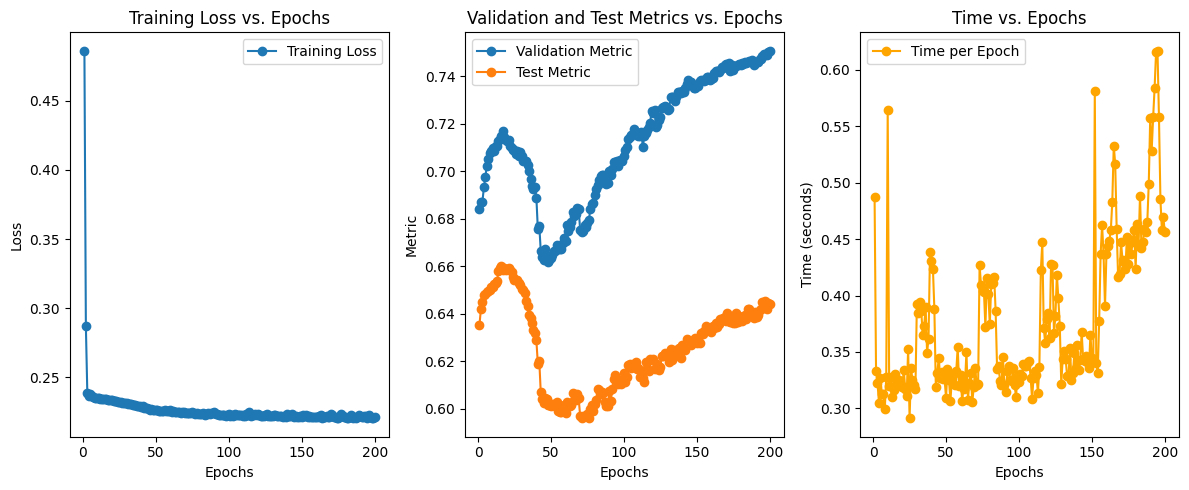

Best Validation Metric: 0.7507861862035141
Test Metric: 0.6441915397970086


In [55]:
# baseline GCNConv comparison
def conv_OGB(dataset_name):
  import os.path as osp
  import time
  from argparse import Namespace
  import numpy as np

  import torch
  import torch.nn.functional as F
  from torch.nn import Linear
  from tqdm import tqdm

  from torch_geometric.datasets import TUDataset
  from torch_geometric.nn import GCNConv, GraphMultisetTransformer
  from torch_geometric.datasets import MoleculeNet
  from torch_geometric.nn import global_mean_pool
  import torch_geometric
  from torch.utils.data import Dataset, DataLoader, random_split
  from torch_geometric.nn import global_mean_pool
  from torch.autograd import Variable

  path = '\tmp\ogb'
  # dataset = MoleculeNet(path, dataset_name).shuffle()
  ### Importing OGB dataset
  from ogb.graphproppred.dataset_pyg import PygGraphPropPredDataset
  from ogb.graphproppred import Evaluator

  dataset = PygGraphPropPredDataset(name=dataset_name)
  evaluator = Evaluator(dataset_name)
  clf_criterion = torch.nn.BCEWithLogitsLoss()

  num_classes = dataset.num_classes
  num_features = dataset.num_features
  num_tasks = dataset.num_tasks
  hidden_channels = 32
  task_type='classification'
  # print(num_classes)

  def collate(data_list):
    batch = torch_geometric.data.Batch.from_data_list(data_list)
    return batch

  total_size = len(dataset)
  train_size = int(0.8 * total_size)
  test_size = (total_size - train_size) // 2
  val_size = total_size - train_size - test_size

  # Use random_split to split the dataset into train, test, and validation sets
  train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate)
  val_loader = DataLoader(val_dataset, batch_size=128, collate_fn=collate)
  test_loader = DataLoader(test_dataset, batch_size=128, collate_fn=collate)

  class NN(torch.nn.Module):
      def __init__(self):
          super().__init__()

          self.conv1 = GCNConv(in_channels=num_features, out_channels=hidden_channels, normalize=True)
          # was hidden, num_tasks
          self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels, normalize=True)
          self.relu = torch.nn.ReLU()

          # was 32, 16
          self.lin1 = Linear(hidden_channels, num_tasks)
          self.lin2 = Linear(16, num_tasks)

      def forward(self, x0, edge_index, batch):
          x = self.conv1(x0, edge_index)
          x = self.relu(x)
          x = self.conv2(x, edge_index)
          x = self.lin1(x)
          # global mean pool instead of GMT, along with other adjustments
          output = global_mean_pool(x, batch)
          # print('output size', output.size())
          # output = output.detach().clone().requires_grad_(True)
          # x = self.lin1(x)
          # output = self.lin2(x)

          return output


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = NN().to(device)
  decoder = NNDecoder(emb_dim = 32, num_tasks = dataset.num_tasks).to(device)
  print(dataset.num_tasks)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  def train(loader):
      model.train()

      total_loss = 0

      epoch_iter = tqdm(loader, ncols=0)
      for step, batch in enumerate(epoch_iter):
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch.x.float(), batch.edge_index, batch.batch)
          is_labeled = ~torch.isnan(batch.y) # Mask NaNs
          loss = clf_criterion(out.float()[is_labeled], batch.y.float()[is_labeled])
          loss.backward()
          # prevent exploding gradients if needed, uncomment
          # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          total_loss += batch.num_graphs * float(loss)
          optimizer.step()
      print('loss returned:', total_loss / len(train_dataset))
      return total_loss / len(train_dataset)


  @torch.no_grad()
  def test(loader):

      model.eval()

      y_true = []
      y_pred = []

      total_same = 0
      epoch_iter = tqdm(loader, ncols=0)
      for step, batch in enumerate(epoch_iter):
          batch = batch.to(device)
          out = model(batch.x.float(), batch.edge_index, batch.batch)
          y_true.append(batch.y.view(out.shape).detach().cpu())
          y_pred.append(out.detach().cpu())
      y_true = torch.cat(y_true, dim = 0).numpy()
      y_pred = torch.cat(y_pred, dim = 0).numpy()
      input_dict = {"y_true": y_true, "y_pred": y_pred}

      return evaluator.eval(input_dict)


  times = []
  training_losses = []
  validation_metrics = []
  test_metrics = []
  for epoch in range(1, 201):
      start = time.time()
      train_loss = train(train_loader)
      val_acc = test(val_loader)
      test_acc = test(test_loader)
      training_losses.append(train_loss)
      validation_metrics.append(val_acc[dataset.eval_metric])
      test_metrics.append(test_acc[dataset.eval_metric])
      print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, '
            f'Val Acc: {val_acc}, Test Acc: {test_acc}')
      times.append(time.time() - start)
  best_val_epoch = np.argmax(np.array(validation_metrics))
  print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")
  plot_training_metrics(training_losses, validation_metrics, test_metrics, times)
  print('Best Validation Metric: {}'.format(validation_metrics[best_val_epoch]))
  print('Test Metric: {}'.format(test_metrics[best_val_epoch]))

conv_OGB('ogbg-moltoxcast')
conv_OGB('ogbg-molclintox')